## IMPORT LIBRARIES

In [63]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader 

from tqdm import tqdm
import heapq
import csv

import numpy as np
import random
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import pandas as pd
import wandb

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



# DATA ANALYSIS AND PREPROCESSING

In [64]:
def data_load(path):
    # input - English
    # output - മലയാളം (Malayalam)
    df = pd.read_csv(path,header=None)
    input_data = df[0].tolist()
    output_data = df[1].tolist()
    return input_data, output_data
def create_char_set(train, val):
    char_set = set()
    for word in train:
        for char in word:
            char_set.add(char)
    for word in val:
        for char in word:
            char_set.add(char)
    return char_set


In [65]:
train_input, train_output = data_load("/kaggle/input/aksharantar-sampled/aksharantar_sampled/mal/mal_train.csv")
val_input, val_output = data_load("/kaggle/input/aksharantar-sampled/aksharantar_sampled/mal/mal_valid.csv")
test_input, test_output = data_load("/kaggle/input/aksharantar-sampled/aksharantar_sampled/mal/mal_test.csv") 
print("Number of training samples: ", len(train_input))
print("Number of validation samples: ", len(val_input))
print("Number of test samples: ", len(test_input))

Number of training samples:  51200
Number of validation samples:  4096
Number of test samples:  4096


In [66]:
eng_chars = create_char_set(train_input, val_input)
print("Total English characters: ",len(eng_chars))
print(sorted(eng_chars))
mal_chars = create_char_set(train_output, val_output)
print("Total Malayalam characters: ",len(mal_chars))
print(sorted(mal_chars))

Total English characters:  26
['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Total Malayalam characters:  70
['ം', 'ഃ', 'അ', 'ആ', 'ഇ', 'ഈ', 'ഉ', 'ഊ', 'ഋ', 'എ', 'ഏ', 'ഐ', 'ഒ', 'ഓ', 'ഔ', 'ക', 'ഖ', 'ഗ', 'ഘ', 'ങ', 'ച', 'ഛ', 'ജ', 'ഝ', 'ഞ', 'ട', 'ഠ', 'ഡ', 'ഢ', 'ണ', 'ത', 'ഥ', 'ദ', 'ധ', 'ന', 'പ', 'ഫ', 'ബ', 'ഭ', 'മ', 'യ', 'ര', 'റ', 'ല', 'ള', 'ഴ', 'വ', 'ശ', 'ഷ', 'സ', 'ഹ', 'ാ', 'ി', 'ീ', 'ു', 'ൂ', 'ൃ', 'െ', 'േ', 'ൈ', 'ൊ', 'ോ', 'ൌ', '്', 'ൗ', 'ൺ', 'ൻ', 'ർ', 'ൽ', 'ൾ']


In [67]:
max_seq_eng = len(max(train_input+val_input+test_input, key=len))
max_seq_mal = len(max(train_output+val_output+test_output, key=len))
print("Length of the longest English word in corpus:",max_seq_eng)
print("Length of the longest Malayalam word in corpus::",max_seq_mal)

Length of the longest English word in corpus: 30
Length of the longest Malayalam word in corpus:: 27


In [68]:
eng_chars_idx = {char: idx + 3 for idx, char in enumerate(sorted(eng_chars))}
eng_chars_idx['0'] = 0 # padding
eng_chars_idx['\t'] = 1 # <SOW>
eng_chars_idx['\n'] = 2 # <EOW>
print(eng_chars_idx)
mal_chars_idx = {char: idx+3 for idx, char in enumerate(sorted(mal_chars))}
mal_chars_idx['0'] = 0 # padding
mal_chars_idx['\t'] = 1 # <SOW>
mal_chars_idx['\n'] = 2 # <EOW>
print(mal_chars_idx)

{'a': 3, 'b': 4, 'c': 5, 'd': 6, 'e': 7, 'f': 8, 'g': 9, 'h': 10, 'i': 11, 'j': 12, 'k': 13, 'l': 14, 'm': 15, 'n': 16, 'o': 17, 'p': 18, 'q': 19, 'r': 20, 's': 21, 't': 22, 'u': 23, 'v': 24, 'w': 25, 'x': 26, 'y': 27, 'z': 28, '0': 0, '\t': 1, '\n': 2}
{'ം': 3, 'ഃ': 4, 'അ': 5, 'ആ': 6, 'ഇ': 7, 'ഈ': 8, 'ഉ': 9, 'ഊ': 10, 'ഋ': 11, 'എ': 12, 'ഏ': 13, 'ഐ': 14, 'ഒ': 15, 'ഓ': 16, 'ഔ': 17, 'ക': 18, 'ഖ': 19, 'ഗ': 20, 'ഘ': 21, 'ങ': 22, 'ച': 23, 'ഛ': 24, 'ജ': 25, 'ഝ': 26, 'ഞ': 27, 'ട': 28, 'ഠ': 29, 'ഡ': 30, 'ഢ': 31, 'ണ': 32, 'ത': 33, 'ഥ': 34, 'ദ': 35, 'ധ': 36, 'ന': 37, 'പ': 38, 'ഫ': 39, 'ബ': 40, 'ഭ': 41, 'മ': 42, 'യ': 43, 'ര': 44, 'റ': 45, 'ല': 46, 'ള': 47, 'ഴ': 48, 'വ': 49, 'ശ': 50, 'ഷ': 51, 'സ': 52, 'ഹ': 53, 'ാ': 54, 'ി': 55, 'ീ': 56, 'ു': 57, 'ൂ': 58, 'ൃ': 59, 'െ': 60, 'േ': 61, 'ൈ': 62, 'ൊ': 63, 'ോ': 64, 'ൌ': 65, '്': 66, 'ൗ': 67, 'ൺ': 68, 'ൻ': 69, 'ർ': 70, 'ൽ': 71, 'ൾ': 72, '0': 0, '\t': 1, '\n': 2}


In [73]:
idx2char_mal = {idx: char for char, idx in mal_chars_idx.items()}
mal_embedd_size = 29
eng_embedd_size = 32


In [70]:
def data_preprocess(data, max_seq, chars_idx):
    # Add start & end tokens and padding
    # sow = "\t" & eow = "\n"
    sow = "\t"
    eow = "\n"
    padded_data = [sow + word + "0" * (max_seq - len(word)) + eow for word in data]
    # Convert sequences to indices
    seq2idx = torch.LongTensor([[chars_idx[char] for char in seq] for seq in padded_data])
    return seq2idx

In [71]:
train_idx_eng = data_preprocess(train_input, max_seq_eng, eng_chars_idx)
train_idx_mal = data_preprocess(train_output, max_seq_mal, mal_chars_idx)
val_idx_eng = data_preprocess(val_input, max_seq_eng, eng_chars_idx)
val_idx_mal = data_preprocess(val_output, max_seq_mal, mal_chars_idx)
test_idx_eng = data_preprocess(test_input, max_seq_eng, eng_chars_idx)
test_idx_mal = data_preprocess(test_output, max_seq_mal, mal_chars_idx)

In [72]:
from torch.utils.data import DataLoader
class Dataset():
    def __init__(self, train_idx_src, train_idx_tgt):
        self.train_idx_src = train_idx_src
        self.train_idx_tgt = train_idx_tgt

    def __len__(self):
        return len(self.train_idx_src)

    def __getitem__(self, idx):
        src_sample = self.train_idx_src[idx]
        tgt_label = self.train_idx_tgt[idx]
        return src_sample, tgt_label

# Assuming train_idx_src and train_idx_tgt are lists or arrays
train_dataset = Dataset(train_idx_eng, train_idx_mal)
val_dataset = Dataset(val_idx_eng, val_idx_mal)
test_dataset = Dataset(test_idx_eng, test_idx_mal)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=True)

## ENCODER PART

In [11]:
# Encoder part
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim = 32, 
                 emb_dim = 256, 
                 enc_hid_dim = 256, 
                 cell_type='gru', 
                 num_layers=2,
                 dropout = 0,
                 bidirectional = True):
        
        super(Encoder, self).__init__()
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.enc_hid_dim = enc_hid_dim
        self.num_layers = num_layers
        # Embedding the input
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.cell_type = cell_type
        # Add dropout
        self.dropout = nn.Dropout(dropout)
        
        # Bidirectional part
        if bidirectional:
            self.val_direction = 2 
        else :
            self.val_direction = 1
            

        if cell_type.lower() == 'rnn':
            self.rnn = nn.RNN(input_size = emb_dim, 
                              hidden_size = enc_hid_dim, 
                              num_layers=num_layers,
                              dropout = dropout,
                              bidirectional= bidirectional,
                              batch_first=True)
        elif cell_type.lower() == 'lstm':
            self.rnn = nn.LSTM(input_size = emb_dim, 
                              hidden_size = enc_hid_dim, 
                              num_layers=num_layers,
                              dropout = dropout,
                              bidirectional= bidirectional,
                              batch_first=True)
        elif cell_type.lower() == 'gru':
            self.rnn = nn.GRU(input_size = emb_dim, 
                              hidden_size = enc_hid_dim, 
                              num_layers=num_layers,
                              dropout = dropout,
                              bidirectional= bidirectional,
                              batch_first=True)
            
            
    def forward(self, src, hidden, cell=None):
        embedded = self.embedding(src)
        embedded = self.dropout(embedded)
        
        if self.cell_type == 'lstm':
            output,(hidden,cell) = self.rnn(embedded, (hidden,cell))
        else:
            output, hidden = self.rnn(embedded, hidden)

        return output, hidden, cell


## DECODER PART

In [12]:
# Decoder part
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim = 29, 
                 emb_dim = 256, 
                 dec_hid_dim = 256, 
                 cell_type='gru', 
                 num_layers=2, 
                 dropout = 0, 
                 bidirectional = True,
                 attention = False,
                 attention_dim = None
                 ):
        
        super(Decoder, self).__init__()
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        # Embedding part
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.attention = attention
        # Dropout to add onto embedded input
        self.dropout = nn.Dropout(dropout)
        self.cell_type = cell_type
        if bidirectional :
            self.val_direction = 2 
        else :
            self.val_direction = 1
            
        # Linear layer to get the output
        self.W1 = nn.Linear(dec_hid_dim * self.val_direction, output_dim)
        # Softmax layer
        self.softmax = F.softmax

        if attention:
            self.attention_dim = attention_dim
            self.input_size += self.attention_dim

            # Attention layer parameters            
            self.U = nn.Sequential(nn.Linear( self.hidden_dimension, self.hidden_dimension), nn.LeakyReLU())
            self.W = nn.Sequential(nn.Linear( self.hidden_dimension, self.hidden_dimension), nn.LeakyReLU())
            self.V = nn.Sequential(nn.Linear( self.hidden_dimension, self.attention_out_dimension), nn.LeakyReLU())
        
        
        if cell_type.lower() == 'rnn':
            self.rnn = nn.LSTM(emb_dim, 
                               dec_hid_dim, 
                               num_layers=num_layers, 
                               dropout = dropout,
                               bidirectional= bidirectional, 
                               batch_first=True)
        elif cell_type.lower() == 'lstm':
            self.rnn = nn.LSTM(emb_dim, 
                               dec_hid_dim, 
                               num_layers=num_layers, 
                               dropout = dropout,
                               bidirectional= bidirectional, 
                               batch_first=True)
        elif cell_type.lower() == 'gru':
            self.rnn = nn.GRU(emb_dim, 
                              dec_hid_dim, 
                              num_layers=num_layers, 
                              dropout = dropout,
                              bidirectional= bidirectional, 
                              batch_first=True)
            
        self.fc_out = nn.Linear(dec_hid_dim, output_dim)
    
    def calculate_attention(hidden, encoder_outputs, enc_hid_dim=256, dec_hid_dim=256):
        attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        v = nn.Linear(dec_hid_dim, 1, bias = False)

        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]

        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        encoder_outputs = encoder_outputs.permute(1, 0, 2)

        energy = torch.tanh(attn(torch.cat((hidden, encoder_outputs), dim = 2))) 
        attention = v(energy).squeeze(2)

        attention_weights = F.softmax(attention, dim=1)
        normalized_context_vector = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs)

        return normalized_context_vector, attention_weights
    
    def forward(self, input, hidden, cell=None,encoder_outputs=None):
#         Incorporate dropout in embedding.
        output = self.dropout(self.embedding(input))
    
        attention_weights = None
#         If we are using attention, then we need to concatenate the context vector, which we obtain from attention
        
        if self.attention:
            context,attention_weights = self.calculate_attention(hidden, encoder_outputs)
            output = torch.cat((output,context),2)
        #print(hidden.shape)
        #print(cell)
        if self.cell_type == 'lstm':
            output,(hidden,cell) = self.decoder_type(output,(hidden,cell))
        else:
            
            output, hidden = self.decoder_type(output, hidden)
            
        
        output = self.W1(output)
        
        return output, hidden, cell, attention_weights

## SEQ2SEQ MODEL

In [14]:
class Seq2Seq(nn.Module):
    
    def __init__(self, 
                 encoder,
                 decoder,
                 dec_inp_dim = 29,
                 enc_hid_dim = 256, 
                 dec_hid_dim =256,
                 bidirectional = True,
                 enc_num_layers = 3,
                 dec_num_layers = 2,
                 cell_type = 'lstm', 
                 dropout = 0.2,
                 attention = False
                ):
        
        
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        # Decoder input dimension
        self.dec_inp_dim = dec_inp_dim
        
        self.enc_hid_dim = enc_hid_dim
        
        # Decoder hidden dimension
        self.dec_hid_dim = dec_hid_dim
        
        # Whether to use bidirectional or not
        self.direction = bidirectional
        self.val_direection = 2 if bidirectional else 1
        
        # Number of layers for encoder and decoder
        self.enc_num_layers = enc_num_layers
        self.dec_num_layers = dec_num_layers
        
        # Which cell type to use
        self.cell_type = cell_type 
        
        # Whether to use dropout or not
        self.dropout = dropout
        
        self.softmax = F.softmax
                
        # Attention mechanism 
        self.attention = attention
        
        # If attention is used, then we need to transform encoder's last hidden to decoder's first hidden
        self.enc_dec_linear1 = nn.Linear(enc_hid_dim,dec_hid_dim)
        self.enc_dec_linear2 = nn.Linear(enc_num_layers*self.val_direection,dec_num_layers*self.val_direection)
        
        # Linear layer to transform encoder's last cell to decoder's first cell
        self.enc_dec_cell_linear1 = nn.Linear(enc_hid_dim,dec_hid_dim)
        self.enc_dec_cell_linear2 = nn.Linear(enc_num_layers*self.val_direection,dec_num_layers*self.val_direection)
        
        # Linear layer to transform encoder's last hidden to decoder's first hidden
        self.enc_dec_att_linear1 = nn.Linear(enc_hid_dim,dec_hid_dim)
        self.enc_dec_att_linear2 = nn.Linear(enc_num_layers*self.val_direection,dec_num_layers*self.val_direection)
        

    
    def forward(self, source, target, teacher_forcing = False):
        batch_size = source.shape[0]
        hidden_dim = torch.zeros(self.val_direction*self.num_layers, batch_size, self.enc_hid_dim, device=device)
        cell_state = torch.zeros(self.val_direction*self.num_layers, batch_size, self.enc_hid_dim, device=device) if self.cell_type == 'lstm' else None
        encoder_outputs = torch.zeros(32,self.val_direection*self.dec_num_layers,batch_size,self.dec_hid_dim,device=device) if self.attention else None

        # Pass source to encoder one character at a time in batch fashion
        for t in range(32):
            encoder_output, hidden_dim, cell_state = self.encoder.process(source[:,t].unsqueeze(0), hidden_dim, cell_state)
            if self.attention:
                hidden_dim_new = self.enc_dec_att_linear1(hidden_dim).permute(2,1,0).contiguous()
                hidden_dim_new = self.enc_dec_att_linear2(hidden_dim_new).permute(2,1,0).contiguous()
                encoder_outputs[t] = hidden_dim_new

        # Encoder's last state is decoders first state
        last_state = hidden_dim
        predictions = torch.zeros(29, batch_size, self.dec_inp_dim,device = device)
        attention_weights = torch.zeros(29, 32, self.val_direection*self.dec_num_layers ,batch_size, device = device)
        decoder_hidden = self.enc_dec_linear1(last_state).permute(2,1,0).contiguous()
        decoder_hidden = self.enc_dec_linear2(decoder_hidden).permute(2,1,0).contiguous()

        # Here also, encoders last cell is decoders first cell, also transform to same dimension
        if  self.cell_type == 'lstm':
            cell_state = self.enc_dec_cell_linear1(cell_state).permute(2,1,0).contiguous()
            cell_state = self.enc_dec_cell_linear2(cell_state).permute(2,1,0).contiguous()

        # output at start is all 1's <SOS>
        output = torch.ones(1,batch_size,dtype=torch.long, device=device)
        predictions[0,:,1]=torch.ones(batch_size)
        attention_wts = None

        # Do decoding by char by char fashion by batch   
        for t in range(1,29):
            if teacher_forcing:
                output, decoder_hidden, cell_state, attention_wts = self.decoder.process(target[:,t-1].unsqueeze(0), decoder_hidden, cell_state, encoder_outputs)
                predictions[t] = output.squeeze(0)
            else:
                output, decoder_hidden, cell_state, attention_wts = self.decoder.process(output, decoder_hidden, cell_state, encoder_outputs)
                predictions[t] = output.squeeze(0)
                if self.attention:
                    attention_weights[t] = attention_wts.squeeze(3)
                output = torch.argmax(self.softmax(output,dim=2),dim=2)

        return predictions, attention_wts

## TRAINING AND ACCURACY

In [ ]:
def train1(model, train_loader, val_loader, epochs):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    optimizer = optim.Adam(model.parameters())
    criterion = nn.CrossEntropyLoss()
    model.train()

    for epoch in tqdm(range(epochs)):
        for phase in ['train', 'val']:
            if phase == 'train':
                data_loader = train_loader
            else:
                data_loader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in data_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs, _ = model(inputs, labels, epoch < epochs/2, phase == 'train')
                    outputs = outputs.permute(1, 0, 2).reshape(-1, 72)
                    labels = F.one_hot(labels, num_classes=72).float().reshape(-1, 72)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        nn.utils.clip_grad_norm_(model.parameters(), 1)
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                preds = torch.argmax(F.softmax(outputs, dim=1), dim=1)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(data_loader.dataset)
            epoch_acc = running_corrects.double() / len(data_loader.dataset)
            print(f'Epoch no: {epoch}')
            if phase == 'train':
                print(f'Train loss: {epoch_loss} \t Train Accuracy: {epoch_acc}')
            else:
                print(f'Validation loss: {valid_loss} \t Validation Accuracy: {val_acc}')
                wandb.log({ 'Epoch': epoch, 'validation_accuracy': epoch_acc * 100})
                wandb.log({ 'Epoch': epoch, 'validation_loss': epoch_loss * 100})

## WANDB SWEEPS WITHOUT ATTENTION

In [16]:
# sweep config file
sweep_config = {
    'method': 'bayes',
    'name' : 'sweep - no attention',
    'metric': {
      'goal': 'maximize',
      'name': 'validation_accuracy'
    },
    'parameters':{
        'input_embedding_size': {
            'values': [64, 128] # 16,32,64,
        },
        'enc_layers': {
            'values': [1,2,3]
        },
        'dec_layers': {
            'values': [1,2,3]
        },
        'hidden_size': {
            'values': [64, 128, 256]
        },
        'cell_type': {
            'values': ['lstm','rnn','gru']
        },
        'bidirectional' : {
            'values' : [True]
        },
        'dropout': {
            'values': [0.1, 0.2, 0.3]
        },
        'beam_size' : {
            'values' : [1,3,5]
        }
     }
}
    
# Create a sweep
sweep_id = wandb.sweep(sweep = sweep_config, entity="abhinavtk", project='MA23M002-A3') # modeling MA23M002-A3
# 4966bf774ea7ce7b47a6e7360b1fad927ece6f1c

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: qbraxyev
Sweep URL: https://wandb.ai/abhinavtk/MA23M002-A3/sweeps/qbraxyev


In [17]:
#wandb sweeps without attention - make sure to use your key for running
def main():
  with wandb.init() as run:
    wandb.run.name = f'cell-{wandb.config.cell_type}_hid_sz-{wandb.config.hidden_size}_inp_embed-{wandb.config.input_embedding_size}_enc-{wandb.config.enc_layers}_dec-{wandb.config.dec_layers}_dropout-{wandb.config.dropout}'
    
    # Encoder part
    encoder = Encoder(
                    embed_dimension = wandb.config.input_embedding_size, 
                    hidden_dimension =  wandb.config.hidden_size,
                    cell_type = wandb.config.cell_type,
                    layers = wandb.config.enc_layers,
                    bidirectional = wandb.config.bidirectional,
                    dropout = wandb.config.dropout
                    )
    # decoder
    decoder = Decoder(
                        emb_dim = wandb.config.input_embedding_size, 
                        dec_hid_dim = wandb.config.hidden_size,
                        cell_type = wandb.config.cell_type,
                        num_layers = wandb.config.dec_layers,
                        dropout = wandb.config.dropout,
                        bidirectional = wandb.config.bidirectional,
                        attention = False,
                        attention_dim = wandb.config.hidden_size
                        )
    # Init model
    model1 = Seq2Seq(encoder,
                     decoder,
                    enc_hid_dim = wandb.config.hidden_size, 
                    dec_hid_dim = wandb.config.hidden_size,
                    bidirectional = wandb.config.bidirectional,
                    encoder_num_layers = wandb.config.enc_layers,
                    decoder_num_layers = wandb.config.dec_layers,
                    cell_type = wandb.config.cell_type, 
                    dropout = wandb.config.dropout, 
                    attention = False
                )
    
    model1.to(device)

    epochs = 15
    train1(model1, train_loader, val_loader, epochs)

wandb.agent(sweep_id, function = main, count = 50) # calls main function for count number of times
wandb.finish()

wandb: Agent Starting Run: u3oyhwy2 with config:
wandb: 	beam_size: 3
wandb: 	bidirectional: True
wandb: 	cell_type: lstm
wandb: 	dec_layers: 1
wandb: 	dropout: 0.1
wandb: 	enc_layers: 3
wandb: 	hidden_size: 128
wandb: 	input_embedding_size: 128
wandb: Currently logged in as: abhinavtk. Use `wandb login --relogin` to force relogin


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  7%|▋         | 1/15 [01:08<15:52, 68.04s/it]

Epoch no: 0
Train loss: 2.8553930985927582 	 Train Accuracy: 0.0
Validation loss: 2.3324717432260513 	 Validation Accuracy: 0.0


 13%|█▎        | 2/15 [02:15<14:36, 67.44s/it]

Epoch no: 1
Train loss: 3.033775951862335 	 Train Accuracy: 0.0
Validation loss: 2.410866692662239 	 Validation Accuracy: 0.0


 20%|██        | 3/15 [03:22<13:26, 67.24s/it]

Epoch no: 2
Train loss: 2.846867252588272 	 Train Accuracy: 1.9531249563442543e-05
Validation loss: 2.2315108478069305 	 Validation Accuracy: 0.00048828125


 27%|██▋       | 4/15 [04:29<12:18, 67.14s/it]

Epoch no: 3
Train loss: 2.792657370567322 	 Train Accuracy: 0.00035156248486600816
Validation loss: 2.11580428481102 	 Validation Accuracy: 0.003662109375


 33%|███▎      | 5/15 [05:36<11:11, 67.13s/it]

Epoch no: 4
Train loss: 2.655674169063568 	 Train Accuracy: 0.0013867187080904841
Validation loss: 1.9639849364757538 	 Validation Accuracy: 0.0048828125


 40%|████      | 6/15 [06:43<10:03, 67.08s/it]

Epoch no: 5
Train loss: 2.5692960345745086 	 Train Accuracy: 0.006874999962747097
Validation loss: 1.873360313475132 	 Validation Accuracy: 0.021240234375


 47%|████▋     | 7/15 [07:50<08:56, 67.05s/it]

Epoch no: 6
Train loss: 2.439165472984314 	 Train Accuracy: 0.020156249403953552
Validation loss: 1.7752407565712929 	 Validation Accuracy: 0.052978515625


 53%|█████▎    | 8/15 [08:57<07:49, 67.09s/it]

Epoch no: 7
Train loss: 2.34011976480484 	 Train Accuracy: 0.03896484151482582
Validation loss: 1.679576963186264 	 Validation Accuracy: 0.0791015625


 60%|██████    | 9/15 [10:04<06:42, 67.06s/it]

Epoch no: 8
Train loss: 1.0900549846887588 	 Train Accuracy: 0.0017187499906867743
Validation loss: 0.8436716049909592 	 Validation Accuracy: 0.013427734375


 67%|██████▋   | 10/15 [11:11<05:35, 67.04s/it]

Epoch no: 9
Train loss: 1.0249604934453964 	 Train Accuracy: 0.003574218600988388
Validation loss: 0.8214132003486156 	 Validation Accuracy: 0.011474609375


 73%|███████▎  | 11/15 [12:18<04:28, 67.07s/it]

Epoch no: 10
Train loss: 0.9436484950780869 	 Train Accuracy: 0.008710937574505806
Validation loss: 0.756726611405611 	 Validation Accuracy: 0.03564453125


 80%|████████  | 12/15 [13:25<03:21, 67.17s/it]

Epoch no: 11
Train loss: 0.8657261002063751 	 Train Accuracy: 0.017910156399011612
Validation loss: 0.6983907148241997 	 Validation Accuracy: 0.04931640625


 87%|████████▋ | 13/15 [14:32<02:14, 67.15s/it]

Epoch no: 12
Train loss: 0.8383366614580154 	 Train Accuracy: 0.020624998956918716
Validation loss: 0.6924838311970234 	 Validation Accuracy: 0.056396484375


 93%|█████████▎| 14/15 [15:40<01:07, 67.12s/it]

Epoch no: 13
Train loss: 0.7831383755803109 	 Train Accuracy: 0.03361327946186066
Validation loss: 0.6608416885137558 	 Validation Accuracy: 0.076904296875


100%|██████████| 15/15 [16:47<00:00, 67.15s/it]

Epoch no: 14
Train loss: 0.7450506231188774 	 Train Accuracy: 0.036796875298023224
Validation loss: 0.6267501190304756 	 Validation Accuracy: 0.075927734375


Epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
validation_accuracy,▁▁▁▁▁▃▆█▂▂▄▅▆██
validation_loss,██▇▇▆▆▆▅▂▂▂▁▁▁▁
Epoch,14
validation_accuracy,7.59277
validation_loss,62.67501


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4e5utncx with config:
wandb: 	beam_size: 5
wandb: 	bidirectional: True
wandb: 	cell_type: rnn
wandb: 	dec_layers: 3
wandb: 	dropout: 0.2
wandb: 	enc_layers: 3
wandb: 	hidden_size: 128
wandb: 	input_embedding_size: 128


  7%|▋         | 1/15 [00:33<07:43, 33.08s/it]

Epoch no: 0
Train loss: 3.568752167224884 	 Train Accuracy: 0.0
Validation loss: 4.000979885458946 	 Validation Accuracy: 0.0


 13%|█▎        | 2/15 [01:06<07:09, 33.05s/it]

Epoch no: 1
Train loss: 3.6814061725139617 	 Train Accuracy: 0.0
Validation loss: 3.2235723584890366 	 Validation Accuracy: 0.0


 20%|██        | 3/15 [01:39<06:36, 33.07s/it]

Epoch no: 2
Train loss: 4.119131338596344 	 Train Accuracy: 0.0
Validation loss: 4.656987875699997 	 Validation Accuracy: 0.0


 27%|██▋       | 4/15 [02:12<06:04, 33.13s/it]

Epoch no: 3
Train loss: 4.240703134536743 	 Train Accuracy: 0.0
Validation loss: 4.820223331451416 	 Validation Accuracy: 0.0


 33%|███▎      | 5/15 [02:45<05:31, 33.12s/it]

Epoch no: 4
Train loss: 4.570911052227021 	 Train Accuracy: 0.0
Validation loss: 5.233895838260651 	 Validation Accuracy: 0.0


 40%|████      | 6/15 [03:18<04:57, 33.10s/it]

Epoch no: 5
Train loss: 4.438149580955505 	 Train Accuracy: 0.0
Validation loss: 5.011792898178101 	 Validation Accuracy: 0.0


 47%|████▋     | 7/15 [03:51<04:24, 33.09s/it]

Epoch no: 6
Train loss: 4.75913762807846 	 Train Accuracy: 0.0
Validation loss: 5.4363319873809814 	 Validation Accuracy: 0.0


 53%|█████▎    | 8/15 [04:24<03:52, 33.15s/it]

Epoch no: 7
Train loss: 4.3766012024879455 	 Train Accuracy: 0.0
Validation loss: 4.937605559825897 	 Validation Accuracy: 0.0


 60%|██████    | 9/15 [04:58<03:18, 33.15s/it]

Epoch no: 8
Train loss: 1.8516916608810425 	 Train Accuracy: 0.0
Validation loss: 1.679816648364067 	 Validation Accuracy: 0.0


 67%|██████▋   | 10/15 [05:31<02:45, 33.15s/it]

Epoch no: 9
Train loss: 1.8493734604120255 	 Train Accuracy: 0.0
Validation loss: 1.6417493149638176 	 Validation Accuracy: 0.0


 73%|███████▎  | 11/15 [06:04<02:12, 33.23s/it]

Epoch no: 10
Train loss: 1.8475779974460602 	 Train Accuracy: 0.0
Validation loss: 1.6583271026611328 	 Validation Accuracy: 0.0


 80%|████████  | 12/15 [06:37<01:39, 33.22s/it]

Epoch no: 11
Train loss: 1.85051429271698 	 Train Accuracy: 0.0
Validation loss: 1.6270692199468613 	 Validation Accuracy: 0.0


 87%|████████▋ | 13/15 [07:11<01:06, 33.21s/it]

Epoch no: 12
Train loss: 1.8484640002250672 	 Train Accuracy: 0.0
Validation loss: 1.6360993459820747 	 Validation Accuracy: 0.0


 93%|█████████▎| 14/15 [07:44<00:33, 33.20s/it]

Epoch no: 13
Train loss: 1.8477270221710205 	 Train Accuracy: 0.0
Validation loss: 1.6795807480812073 	 Validation Accuracy: 0.0


100%|██████████| 15/15 [08:17<00:00, 33.17s/it]

Epoch no: 14
Train loss: 1.8477514618635178 	 Train Accuracy: 0.0
Validation loss: 1.667956918478012 	 Validation Accuracy: 0.0


Epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
validation_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,▅▄▇▇█▇█▇▁▁▁▁▁▁▁
Epoch,14
validation_accuracy,0.0
validation_loss,166.79569


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: c2z1gozu with config:
wandb: 	beam_size: 1
wandb: 	bidirectional: True
wandb: 	cell_type: rnn
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	enc_layers: 2
wandb: 	hidden_size: 128
wandb: 	input_embedding_size: 128


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  7%|▋         | 1/15 [00:18<04:24, 18.92s/it]

Epoch no: 0
Train loss: 3.3509339249134062 	 Train Accuracy: 0.0
Validation loss: 3.743854433298111 	 Validation Accuracy: 0.0


 13%|█▎        | 2/15 [00:37<04:05, 18.89s/it]

Epoch no: 1
Train loss: 3.657974874973297 	 Train Accuracy: 0.0
Validation loss: 4.106095492839813 	 Validation Accuracy: 0.0


 20%|██        | 3/15 [00:56<03:47, 18.93s/it]

Epoch no: 2
Train loss: 3.566841733455658 	 Train Accuracy: 0.0
Validation loss: 2.815134048461914 	 Validation Accuracy: 0.0


 27%|██▋       | 4/15 [01:15<03:27, 18.89s/it]

Epoch no: 3
Train loss: 3.7798040997982025 	 Train Accuracy: 0.0
Validation loss: 4.142942816019058 	 Validation Accuracy: 0.0


 33%|███▎      | 5/15 [01:34<03:08, 18.83s/it]

Epoch no: 4
Train loss: 3.775529661178589 	 Train Accuracy: 0.0
Validation loss: 2.99627947807312 	 Validation Accuracy: 0.0


 40%|████      | 6/15 [01:53<02:49, 18.79s/it]

Epoch no: 5
Train loss: 3.828689877986908 	 Train Accuracy: 0.0
Validation loss: 3.2260607928037643 	 Validation Accuracy: 0.0


 47%|████▋     | 7/15 [02:11<02:30, 18.81s/it]

Epoch no: 6
Train loss: 4.031688261032104 	 Train Accuracy: 0.0
Validation loss: 4.4818766713142395 	 Validation Accuracy: 0.0


 53%|█████▎    | 8/15 [02:30<02:11, 18.79s/it]

Epoch no: 7
Train loss: 4.1765110504627225 	 Train Accuracy: 0.0
Validation loss: 4.665715843439102 	 Validation Accuracy: 0.0


 60%|██████    | 9/15 [02:49<01:52, 18.76s/it]

Epoch no: 8
Train loss: 1.8508204787969589 	 Train Accuracy: 0.0
Validation loss: 1.6500524282455444 	 Validation Accuracy: 0.0


 67%|██████▋   | 10/15 [03:07<01:33, 18.72s/it]

Epoch no: 9
Train loss: 1.8486862868070602 	 Train Accuracy: 0.0
Validation loss: 1.657193347811699 	 Validation Accuracy: 0.0


 73%|███████▎  | 11/15 [03:26<01:15, 18.77s/it]

Epoch no: 10
Train loss: 1.8507851374149322 	 Train Accuracy: 0.0
Validation loss: 1.6807104349136353 	 Validation Accuracy: 0.0


 80%|████████  | 12/15 [03:45<00:56, 18.77s/it]

Epoch no: 11
Train loss: 1.8487924826145172 	 Train Accuracy: 0.0
Validation loss: 1.6596610471606255 	 Validation Accuracy: 0.0


 87%|████████▋ | 13/15 [04:04<00:37, 18.73s/it]

Epoch no: 12
Train loss: 1.848656925559044 	 Train Accuracy: 0.0
Validation loss: 1.6560762599110603 	 Validation Accuracy: 0.0


 93%|█████████▎| 14/15 [04:23<00:18, 18.77s/it]

Epoch no: 13
Train loss: 1.8482363623380662 	 Train Accuracy: 0.0
Validation loss: 1.6685729026794434 	 Validation Accuracy: 0.0


100%|██████████| 15/15 [04:41<00:00, 18.77s/it]

Epoch no: 14
Train loss: 1.8560416316986084 	 Train Accuracy: 0.0
Validation loss: 1.7136422023177147 	 Validation Accuracy: 0.0


Epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
validation_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,▆▇▄▇▄▅██▁▁▁▁▁▁▁
Epoch,14
validation_accuracy,0.0
validation_loss,171.36422


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: usfz1gjy with config:
wandb: 	beam_size: 5
wandb: 	bidirectional: True
wandb: 	cell_type: lstm
wandb: 	dec_layers: 2
wandb: 	dropout: 0.2
wandb: 	enc_layers: 3
wandb: 	hidden_size: 256
wandb: 	input_embedding_size: 128


  7%|▋         | 1/15 [00:35<08:15, 35.39s/it]

Epoch no: 0
Train loss: 3.021771981716156 	 Train Accuracy: 0.0
Validation loss: 2.5871879905462265 	 Validation Accuracy: 0.0


 13%|█▎        | 2/15 [01:10<07:38, 35.24s/it]

Epoch no: 1
Train loss: 3.1412013638019562 	 Train Accuracy: 1.9531249563442543e-05
Validation loss: 2.484946072101593 	 Validation Accuracy: 0.0


 20%|██        | 3/15 [01:45<07:03, 35.28s/it]

Epoch no: 2
Train loss: 2.770400381088257 	 Train Accuracy: 0.005253906361758709
Validation loss: 2.0459895879030228 	 Validation Accuracy: 0.018798828125


 27%|██▋       | 4/15 [02:20<06:27, 35.21s/it]

Epoch no: 3
Train loss: 2.4225813031196592 	 Train Accuracy: 0.051386717706918716
Validation loss: 1.729983665049076 	 Validation Accuracy: 0.089111328125


 33%|███▎      | 5/15 [02:56<05:51, 35.19s/it]

Epoch no: 4
Train loss: 1.9515082067251206 	 Train Accuracy: 0.15585936605930328
Validation loss: 1.4383804649114609 	 Validation Accuracy: 0.191650390625


 40%|████      | 6/15 [03:31<05:16, 35.18s/it]

Epoch no: 5
Train loss: 1.5513808375597 	 Train Accuracy: 0.2796289026737213
Validation loss: 1.212377592921257 	 Validation Accuracy: 0.2685546875


 47%|████▋     | 7/15 [04:06<04:42, 35.25s/it]

Epoch no: 6
Train loss: 1.3138272005319596 	 Train Accuracy: 0.3736328184604645
Validation loss: 1.1401023119688034 	 Validation Accuracy: 0.32080078125


 53%|█████▎    | 8/15 [04:41<04:06, 35.23s/it]

Epoch no: 7
Train loss: 1.0931648051738738 	 Train Accuracy: 0.4581835865974426
Validation loss: 1.0357888154685497 	 Validation Accuracy: 0.388427734375


 60%|██████    | 9/15 [05:17<03:31, 35.30s/it]

Epoch no: 8
Train loss: 0.6074286812543869 	 Train Accuracy: 0.21230468153953552
Validation loss: 0.548311248421669 	 Validation Accuracy: 0.22509765625


 67%|██████▋   | 10/15 [05:52<02:56, 35.35s/it]

Epoch no: 9
Train loss: 0.5086597526073455 	 Train Accuracy: 0.30839842557907104
Validation loss: 0.5148273762315512 	 Validation Accuracy: 0.30029296875


 73%|███████▎  | 11/15 [06:28<02:21, 35.34s/it]

Epoch no: 10
Train loss: 0.48162018686532976 	 Train Accuracy: 0.3340234160423279
Validation loss: 0.5125667843967676 	 Validation Accuracy: 0.293212890625


 80%|████████  | 12/15 [07:03<01:45, 35.29s/it]

Epoch no: 11
Train loss: 0.41086871951818466 	 Train Accuracy: 0.40187498927116394
Validation loss: 0.4666744638234377 	 Validation Accuracy: 0.33349609375


 87%|████████▋ | 13/15 [07:38<01:10, 35.28s/it]

Epoch no: 12
Train loss: 0.3682207053899765 	 Train Accuracy: 0.460273414850235
Validation loss: 0.46215592697262764 	 Validation Accuracy: 0.363525390625


 93%|█████████▎| 14/15 [08:13<00:35, 35.32s/it]

Epoch no: 13
Train loss: 0.36222205698490145 	 Train Accuracy: 0.4690820276737213
Validation loss: 0.4564096573740244 	 Validation Accuracy: 0.373291015625


100%|██████████| 15/15 [08:49<00:00, 35.28s/it]

Epoch no: 14
Train loss: 0.31667947590351103 	 Train Accuracy: 0.5301171541213989
Validation loss: 0.44425964541733265 	 Validation Accuracy: 0.391357421875


Epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
validation_accuracy,▁▁▁▃▄▆▇█▅▆▆▇███
validation_loss,██▆▅▄▄▃▃▁▁▁▁▁▁▁
Epoch,14
validation_accuracy,39.13574
validation_loss,44.42596


wandb: Agent Starting Run: vqs5umr7 with config:
wandb: 	beam_size: 5
wandb: 	bidirectional: True
wandb: 	cell_type: rnn
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	enc_layers: 1
wandb: 	hidden_size: 128
wandb: 	input_embedding_size: 128


  7%|▋         | 1/15 [00:14<03:27, 14.80s/it]

Epoch no: 0
Train loss: 3.420395953655243 	 Train Accuracy: 0.0
Validation loss: 3.874424561858177 	 Validation Accuracy: 0.0


 13%|█▎        | 2/15 [00:29<03:13, 14.89s/it]

Epoch no: 1
Train loss: 3.229787521362305 	 Train Accuracy: 0.0
Validation loss: 3.1882782727479935 	 Validation Accuracy: 0.0


 20%|██        | 3/15 [00:44<02:57, 14.83s/it]

Epoch no: 2
Train loss: 3.5335409212112427 	 Train Accuracy: 0.0
Validation loss: 3.839821845293045 	 Validation Accuracy: 0.0


 27%|██▋       | 4/15 [00:59<02:42, 14.74s/it]

Epoch no: 3
Train loss: 3.680651149749756 	 Train Accuracy: 0.0
Validation loss: 2.963704913854599 	 Validation Accuracy: 0.0


 33%|███▎      | 5/15 [01:13<02:27, 14.76s/it]

Epoch no: 4
Train loss: 3.749052644968033 	 Train Accuracy: 0.0
Validation loss: 3.1929595470428467 	 Validation Accuracy: 0.0


 40%|████      | 6/15 [01:28<02:13, 14.80s/it]

Epoch no: 5
Train loss: 3.736820707321167 	 Train Accuracy: 0.0
Validation loss: 3.208173856139183 	 Validation Accuracy: 0.0


 47%|████▋     | 7/15 [01:43<01:58, 14.76s/it]

Epoch no: 6
Train loss: 3.8804034423828124 	 Train Accuracy: 0.0
Validation loss: 4.192405492067337 	 Validation Accuracy: 0.0


 53%|█████▎    | 8/15 [01:58<01:43, 14.77s/it]

Epoch no: 7
Train loss: 4.815456714630127 	 Train Accuracy: 0.0
Validation loss: 5.4680100083351135 	 Validation Accuracy: 0.0


 60%|██████    | 9/15 [02:13<01:28, 14.83s/it]

Epoch no: 8
Train loss: 1.8518210685253143 	 Train Accuracy: 0.0
Validation loss: 1.669987328350544 	 Validation Accuracy: 0.0


 67%|██████▋   | 10/15 [02:28<01:14, 14.87s/it]

Epoch no: 9
Train loss: 1.8504940837621688 	 Train Accuracy: 0.0
Validation loss: 1.6429253742098808 	 Validation Accuracy: 0.0


 73%|███████▎  | 11/15 [02:42<00:59, 14.86s/it]

Epoch no: 10
Train loss: 1.8487264305353164 	 Train Accuracy: 0.0
Validation loss: 1.658228561282158 	 Validation Accuracy: 0.0


 80%|████████  | 12/15 [02:57<00:44, 14.85s/it]

Epoch no: 11
Train loss: 1.84998876452446 	 Train Accuracy: 0.0
Validation loss: 1.6486383080482483 	 Validation Accuracy: 0.0


 87%|████████▋ | 13/15 [03:12<00:29, 14.85s/it]

Epoch no: 12
Train loss: 1.850539224743843 	 Train Accuracy: 0.0
Validation loss: 1.6397674828767776 	 Validation Accuracy: 0.0


 93%|█████████▎| 14/15 [03:27<00:14, 14.84s/it]

Epoch no: 13
Train loss: 1.8484835195541383 	 Train Accuracy: 0.0
Validation loss: 1.6519982814788818 	 Validation Accuracy: 0.0


100%|██████████| 15/15 [03:42<00:00, 14.82s/it]

Epoch no: 14
Train loss: 1.847270959019661 	 Train Accuracy: 0.0
Validation loss: 1.6592950224876404 	 Validation Accuracy: 0.0


Epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
validation_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,▅▄▅▃▄▄▆█▁▁▁▁▁▁▁
Epoch,14
validation_accuracy,0.0
validation_loss,165.9295


wandb: Agent Starting Run: v0ryv67k with config:
wandb: 	beam_size: 1
wandb: 	bidirectional: True
wandb: 	cell_type: rnn
wandb: 	dec_layers: 3
wandb: 	dropout: 0.3
wandb: 	enc_layers: 3
wandb: 	hidden_size: 64
wandb: 	input_embedding_size: 64


  7%|▋         | 1/15 [00:21<05:01, 21.56s/it]

Epoch no: 0
Train loss: 2.9939339470863344 	 Train Accuracy: 0.0
Validation loss: 2.570403516292572 	 Validation Accuracy: 0.0


 13%|█▎        | 2/15 [00:43<04:40, 21.55s/it]

Epoch no: 1
Train loss: 3.2842196559906007 	 Train Accuracy: 0.0
Validation loss: 3.5604140013456345 	 Validation Accuracy: 0.0


 20%|██        | 3/15 [01:04<04:17, 21.44s/it]

Epoch no: 2
Train loss: 3.382478710412979 	 Train Accuracy: 0.0
Validation loss: 3.6371231377124786 	 Validation Accuracy: 0.0


 27%|██▋       | 4/15 [01:26<03:56, 21.50s/it]

Epoch no: 3
Train loss: 3.5215764009952544 	 Train Accuracy: 0.0
Validation loss: 3.77785287797451 	 Validation Accuracy: 0.0


 33%|███▎      | 5/15 [01:47<03:34, 21.48s/it]

Epoch no: 4
Train loss: 4.001956015825272 	 Train Accuracy: 0.0
Validation loss: 4.514605641365051 	 Validation Accuracy: 0.0


 40%|████      | 6/15 [02:09<03:13, 21.53s/it]

Epoch no: 5
Train loss: 4.057338786125183 	 Train Accuracy: 0.0
Validation loss: 4.578393131494522 	 Validation Accuracy: 0.0


 47%|████▋     | 7/15 [02:30<02:52, 21.52s/it]

Epoch no: 6
Train loss: 4.120617591142654 	 Train Accuracy: 0.0
Validation loss: 4.6269576251506805 	 Validation Accuracy: 0.0


 53%|█████▎    | 8/15 [02:52<02:30, 21.51s/it]

Epoch no: 7
Train loss: 4.501332049369812 	 Train Accuracy: 0.0
Validation loss: 5.017882257699966 	 Validation Accuracy: 0.0


 60%|██████    | 9/15 [03:13<02:09, 21.54s/it]

Epoch no: 8
Train loss: 1.8502718198299408 	 Train Accuracy: 0.0
Validation loss: 1.653201401233673 	 Validation Accuracy: 0.0


 67%|██████▋   | 10/15 [03:34<01:47, 21.46s/it]

Epoch no: 9
Train loss: 1.8491437596082687 	 Train Accuracy: 0.0
Validation loss: 1.6479439064860344 	 Validation Accuracy: 0.0


 73%|███████▎  | 11/15 [03:56<01:25, 21.45s/it]

Epoch no: 10
Train loss: 1.848702666759491 	 Train Accuracy: 0.0
Validation loss: 1.6409103721380234 	 Validation Accuracy: 0.0


 80%|████████  | 12/15 [04:17<01:04, 21.46s/it]

Epoch no: 11
Train loss: 1.8482126414775848 	 Train Accuracy: 0.0
Validation loss: 1.6374647319316864 	 Validation Accuracy: 0.0


 87%|████████▋ | 13/15 [04:39<00:42, 21.49s/it]

Epoch no: 12
Train loss: 1.847546595931053 	 Train Accuracy: 0.0
Validation loss: 1.6498133465647697 	 Validation Accuracy: 0.0


 93%|█████████▎| 14/15 [05:00<00:21, 21.43s/it]

Epoch no: 13
Train loss: 1.846525564789772 	 Train Accuracy: 0.0
Validation loss: 1.6617157831788063 	 Validation Accuracy: 0.0


100%|██████████| 15/15 [05:22<00:00, 21.48s/it]

Epoch no: 14
Train loss: 1.846416928768158 	 Train Accuracy: 0.0
Validation loss: 1.6555226743221283 	 Validation Accuracy: 0.0


Epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
validation_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,▃▅▅▅▇▇▇█▁▁▁▁▁▁▁
Epoch,14
validation_accuracy,0.0
validation_loss,165.55227


wandb: Agent Starting Run: q67394dj with config:
wandb: 	beam_size: 5
wandb: 	bidirectional: True
wandb: 	cell_type: gru
wandb: 	dec_layers: 3
wandb: 	dropout: 0.2
wandb: 	enc_layers: 2
wandb: 	hidden_size: 256
wandb: 	input_embedding_size: 128


  7%|▋         | 1/15 [00:28<06:39, 28.51s/it]

Epoch no: 0
Train loss: 2.980648694038391 	 Train Accuracy: 0.00011718749738065526
Validation loss: 2.3800396621227264 	 Validation Accuracy: 0.00048828125


 13%|█▎        | 2/15 [00:57<06:12, 28.64s/it]

Epoch no: 1
Train loss: 2.3360829186439513 	 Train Accuracy: 0.04447265341877937
Validation loss: 1.7037636265158653 	 Validation Accuracy: 0.078857421875


 20%|██        | 3/15 [01:25<05:42, 28.54s/it]

Epoch no: 2
Train loss: 1.767325341105461 	 Train Accuracy: 0.19615234434604645
Validation loss: 1.317041538655758 	 Validation Accuracy: 0.2314453125


 27%|██▋       | 4/15 [01:54<05:13, 28.52s/it]

Epoch no: 3
Train loss: 1.4249869304895402 	 Train Accuracy: 0.31654295325279236
Validation loss: 1.1663043200969696 	 Validation Accuracy: 0.30615234375


 33%|███▎      | 5/15 [02:22<04:45, 28.55s/it]

Epoch no: 4
Train loss: 1.1395482248067856 	 Train Accuracy: 0.4222656190395355
Validation loss: 1.084363054484129 	 Validation Accuracy: 0.359619140625


 40%|████      | 6/15 [02:51<04:16, 28.54s/it]

Epoch no: 5
Train loss: 1.0462174358963967 	 Train Accuracy: 0.47507810592651367
Validation loss: 1.0392605252563953 	 Validation Accuracy: 0.393798828125


 47%|████▋     | 7/15 [03:19<03:48, 28.53s/it]

Epoch no: 6
Train loss: 0.8896762159466743 	 Train Accuracy: 0.5457421541213989
Validation loss: 1.0287329740822315 	 Validation Accuracy: 0.407470703125


 53%|█████▎    | 8/15 [03:48<03:19, 28.49s/it]

Epoch no: 7
Train loss: 0.8392428347468376 	 Train Accuracy: 0.5935742259025574
Validation loss: 1.0279860012233257 	 Validation Accuracy: 0.43017578125


 60%|██████    | 9/15 [04:16<02:50, 28.49s/it]

Epoch no: 8
Train loss: 0.5687589064240456 	 Train Accuracy: 0.2581835985183716
Validation loss: 0.5379853453487158 	 Validation Accuracy: 0.271240234375


 67%|██████▋   | 10/15 [04:45<02:22, 28.45s/it]

Epoch no: 9
Train loss: 0.4650713329017162 	 Train Accuracy: 0.36564451456069946
Validation loss: 0.49169321544468403 	 Validation Accuracy: 0.319091796875


 73%|███████▎  | 11/15 [05:13<01:53, 28.48s/it]

Epoch no: 10
Train loss: 0.408611703068018 	 Train Accuracy: 0.43025389313697815
Validation loss: 0.4720391947776079 	 Validation Accuracy: 0.361083984375


 80%|████████  | 12/15 [05:42<01:25, 28.50s/it]

Epoch no: 11
Train loss: 0.36737012952566145 	 Train Accuracy: 0.48347654938697815
Validation loss: 0.4637925736606121 	 Validation Accuracy: 0.377685546875


 87%|████████▋ | 13/15 [06:10<00:57, 28.54s/it]

Epoch no: 12
Train loss: 0.34218657404184344 	 Train Accuracy: 0.5004101395606995
Validation loss: 0.4617843870073557 	 Validation Accuracy: 0.37451171875


 93%|█████████▎| 14/15 [06:39<00:28, 28.49s/it]

Epoch no: 13
Train loss: 0.32448024466633796 	 Train Accuracy: 0.5355077981948853
Validation loss: 0.45722581446170807 	 Validation Accuracy: 0.404296875


100%|██████████| 15/15 [07:07<00:00, 28.49s/it]

Epoch no: 14
Train loss: 0.2907548522949219 	 Train Accuracy: 0.5780078172683716
Validation loss: 0.45718290470540524 	 Validation Accuracy: 0.415283203125


Epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
validation_accuracy,▁▂▅▆▇▇██▅▆▇▇▇██
validation_loss,█▆▄▄▃▃▃▃▁▁▁▁▁▁▁
Epoch,14
validation_accuracy,41.52832
validation_loss,45.71829


wandb: Agent Starting Run: w9eny9h5 with config:
wandb: 	beam_size: 1
wandb: 	bidirectional: True
wandb: 	cell_type: gru
wandb: 	dec_layers: 3
wandb: 	dropout: 0.2
wandb: 	enc_layers: 1
wandb: 	hidden_size: 64
wandb: 	input_embedding_size: 64


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  7%|▋         | 1/15 [00:20<04:45, 20.39s/it]

Epoch no: 0
Train loss: 2.9473059689998626 	 Train Accuracy: 0.0
Validation loss: 2.3670448660850525 	 Validation Accuracy: 0.0


 13%|█▎        | 2/15 [00:40<04:23, 20.28s/it]

Epoch no: 1
Train loss: 3.385670177936554 	 Train Accuracy: 0.0
Validation loss: 2.8979554921388626 	 Validation Accuracy: 0.0


 20%|██        | 3/15 [01:00<04:03, 20.28s/it]

Epoch no: 2
Train loss: 3.1161324691772463 	 Train Accuracy: 0.0
Validation loss: 2.5514592826366425 	 Validation Accuracy: 0.0


 27%|██▋       | 4/15 [01:21<03:42, 20.26s/it]

Epoch no: 3
Train loss: 3.2630918717384336 	 Train Accuracy: 0.0
Validation loss: 2.6538427025079727 	 Validation Accuracy: 0.0


 33%|███▎      | 5/15 [01:41<03:23, 20.32s/it]

Epoch no: 4
Train loss: 3.3409283351898194 	 Train Accuracy: 0.0
Validation loss: 2.689243108034134 	 Validation Accuracy: 0.000244140625


 40%|████      | 6/15 [02:01<03:02, 20.32s/it]

Epoch no: 5
Train loss: 3.5728332483768463 	 Train Accuracy: 3.9062499126885086e-05
Validation loss: 2.7842519283294678 	 Validation Accuracy: 0.000244140625


 47%|████▋     | 7/15 [02:22<02:42, 20.31s/it]

Epoch no: 6
Train loss: 3.567117601633072 	 Train Accuracy: 3.9062499126885086e-05
Validation loss: 2.8677688390016556 	 Validation Accuracy: 0.0


 53%|█████▎    | 8/15 [02:42<02:22, 20.29s/it]

Epoch no: 7
Train loss: 3.374028123617172 	 Train Accuracy: 9.765624417923391e-05
Validation loss: 2.555385649204254 	 Validation Accuracy: 0.000732421875


 60%|██████    | 9/15 [03:02<02:02, 20.36s/it]

Epoch no: 8
Train loss: 1.449399973154068 	 Train Accuracy: 0.0
Validation loss: 1.1264081448316574 	 Validation Accuracy: 0.0


 67%|██████▋   | 10/15 [03:23<01:41, 20.37s/it]

Epoch no: 9
Train loss: 1.3894400352239609 	 Train Accuracy: 1.9531249563442543e-05
Validation loss: 1.0886744558811188 	 Validation Accuracy: 0.00048828125


 73%|███████▎  | 11/15 [03:43<01:21, 20.35s/it]

Epoch no: 10
Train loss: 1.4041687393188476 	 Train Accuracy: 3.9062499126885086e-05
Validation loss: 1.1023909971117973 	 Validation Accuracy: 0.000244140625


 80%|████████  | 12/15 [04:04<01:01, 20.42s/it]

Epoch no: 11
Train loss: 1.3080808663368224 	 Train Accuracy: 9.765624417923391e-05
Validation loss: 1.0181897729635239 	 Validation Accuracy: 0.001708984375


 87%|████████▋ | 13/15 [04:24<00:40, 20.38s/it]

Epoch no: 12
Train loss: 1.2950902909040451 	 Train Accuracy: 9.765624417923391e-05
Validation loss: 1.006395023316145 	 Validation Accuracy: 0.0029296875


 93%|█████████▎| 14/15 [04:44<00:20, 20.32s/it]

Epoch no: 13
Train loss: 1.241888765692711 	 Train Accuracy: 0.00017578124243300408
Validation loss: 0.9702854380011559 	 Validation Accuracy: 0.0029296875


100%|██████████| 15/15 [05:04<00:00, 20.33s/it]

Epoch no: 14
Train loss: 1.2427761715650558 	 Train Accuracy: 0.00025390624068677425
Validation loss: 0.9700538665056229 	 Validation Accuracy: 0.002197265625


Epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
validation_accuracy,▁▁▁▁▂▂▁▃▁▂▂▅██▆
validation_loss,▆█▇▇▇██▇▂▁▁▁▁▁▁
Epoch,14
validation_accuracy,0.21973
validation_loss,97.00539


wandb: Agent Starting Run: qihim0vt with config:
wandb: 	beam_size: 1
wandb: 	bidirectional: True
wandb: 	cell_type: lstm
wandb: 	dec_layers: 1
wandb: 	dropout: 0.2
wandb: 	enc_layers: 3
wandb: 	hidden_size: 256
wandb: 	input_embedding_size: 128


  7%|▋         | 1/15 [00:31<07:20, 31.46s/it]

Epoch no: 0
Train loss: 3.386139544248581 	 Train Accuracy: 0.0
Validation loss: 2.9699164777994156 	 Validation Accuracy: 0.0


 13%|█▎        | 2/15 [01:02<06:47, 31.35s/it]

Epoch no: 1
Train loss: 3.2412552607059477 	 Train Accuracy: 0.0
Validation loss: 2.7369000017642975 	 Validation Accuracy: 0.0


 20%|██        | 3/15 [01:34<06:16, 31.35s/it]

Epoch no: 2
Train loss: 3.1298895728588105 	 Train Accuracy: 0.0
Validation loss: 2.4431368112564087 	 Validation Accuracy: 0.000244140625


 27%|██▋       | 4/15 [02:05<05:46, 31.46s/it]

Epoch no: 3
Train loss: 3.018228645324707 	 Train Accuracy: 0.0009179687476716936
Validation loss: 2.302391141653061 	 Validation Accuracy: 0.00390625


 33%|███▎      | 5/15 [02:36<05:13, 31.35s/it]

Epoch no: 4
Train loss: 2.7299897801876067 	 Train Accuracy: 0.010996093042194843
Validation loss: 2.014097161591053 	 Validation Accuracy: 0.036376953125


 40%|████      | 6/15 [03:08<04:42, 31.35s/it]

Epoch no: 5
Train loss: 2.396419001817703 	 Train Accuracy: 0.048710934817790985
Validation loss: 1.6992056295275688 	 Validation Accuracy: 0.09765625


 47%|████▋     | 7/15 [03:39<04:10, 31.37s/it]

Epoch no: 6
Train loss: 2.1343546587228777 	 Train Accuracy: 0.09980468451976776
Validation loss: 1.5129340812563896 	 Validation Accuracy: 0.147216796875


 53%|█████▎    | 8/15 [04:11<03:40, 31.43s/it]

Epoch no: 7
Train loss: 1.8269312220811844 	 Train Accuracy: 0.18017578125
Validation loss: 1.3738030791282654 	 Validation Accuracy: 0.20703125


 60%|██████    | 9/15 [04:42<03:08, 31.41s/it]

Epoch no: 8
Train loss: 0.9960100370645523 	 Train Accuracy: 0.0026171873323619366
Validation loss: 0.8101467229425907 	 Validation Accuracy: 0.0107421875


 67%|██████▋   | 10/15 [05:13<02:36, 31.38s/it]

Epoch no: 9
Train loss: 0.833975006043911 	 Train Accuracy: 0.03236328065395355
Validation loss: 0.6821107789874077 	 Validation Accuracy: 0.0625


 73%|███████▎  | 11/15 [05:45<02:05, 31.42s/it]

Epoch no: 10
Train loss: 0.7536504924297333 	 Train Accuracy: 0.06123046576976776
Validation loss: 0.6234171502292156 	 Validation Accuracy: 0.111083984375


 80%|████████  | 12/15 [06:16<01:34, 31.48s/it]

Epoch no: 11
Train loss: 0.7132586839795113 	 Train Accuracy: 0.08720702677965164
Validation loss: 0.6081461012363434 	 Validation Accuracy: 0.134765625


 87%|████████▋ | 13/15 [06:48<01:02, 31.44s/it]

Epoch no: 12
Train loss: 0.6186689805984497 	 Train Accuracy: 0.1413867175579071
Validation loss: 0.5596712715923786 	 Validation Accuracy: 0.172607421875


 93%|█████████▎| 14/15 [07:19<00:31, 31.40s/it]

Epoch no: 13
Train loss: 0.6183606514334679 	 Train Accuracy: 0.1312890648841858
Validation loss: 0.5738036073744297 	 Validation Accuracy: 0.16162109375


100%|██████████| 15/15 [07:50<00:00, 31.39s/it]

Epoch no: 14
Train loss: 0.5284742327034473 	 Train Accuracy: 0.21914061903953552
Validation loss: 0.5305013097822666 	 Validation Accuracy: 0.222412109375


Epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
validation_accuracy,▁▁▁▁▂▄▆█▁▃▄▅▆▆█
validation_loss,█▇▆▆▅▄▄▃▂▁▁▁▁▁▁
Epoch,14
validation_accuracy,22.24121
validation_loss,53.05013


wandb: Agent Starting Run: 23lyxqd2 with config:
wandb: 	beam_size: 5
wandb: 	bidirectional: True
wandb: 	cell_type: rnn
wandb: 	dec_layers: 3
wandb: 	dropout: 0.2
wandb: 	enc_layers: 2
wandb: 	hidden_size: 256
wandb: 	input_embedding_size: 64


  7%|▋         | 1/15 [01:10<16:27, 70.53s/it]

Epoch no: 0
Train loss: 3.4684085953235626 	 Train Accuracy: 0.0
Validation loss: 3.2447059601545334 	 Validation Accuracy: 0.0


 13%|█▎        | 2/15 [02:21<15:16, 70.52s/it]

Epoch no: 1
Train loss: 3.905040216445923 	 Train Accuracy: 0.0
Validation loss: 4.230392128229141 	 Validation Accuracy: 0.0


 20%|██        | 3/15 [03:31<14:07, 70.62s/it]

Epoch no: 2
Train loss: 3.959469281435013 	 Train Accuracy: 0.0
Validation loss: 4.215589880943298 	 Validation Accuracy: 0.0


 27%|██▋       | 4/15 [04:42<12:58, 70.78s/it]

Epoch no: 3
Train loss: 4.228192543983459 	 Train Accuracy: 0.0
Validation loss: 4.343989253044128 	 Validation Accuracy: 0.0


 33%|███▎      | 5/15 [05:53<11:46, 70.67s/it]

Epoch no: 4
Train loss: 4.709787969589233 	 Train Accuracy: 0.0
Validation loss: 5.223104745149612 	 Validation Accuracy: 0.0


 40%|████      | 6/15 [07:03<10:35, 70.61s/it]

Epoch no: 5
Train loss: 5.0548640775680544 	 Train Accuracy: 0.0
Validation loss: 5.7452846467494965 	 Validation Accuracy: 0.0


 47%|████▋     | 7/15 [08:14<09:24, 70.57s/it]

Epoch no: 6
Train loss: 5.280379469394684 	 Train Accuracy: 0.0
Validation loss: 5.894157558679581 	 Validation Accuracy: 0.0


 53%|█████▎    | 8/15 [09:24<08:14, 70.60s/it]

Epoch no: 7
Train loss: 4.377259013652801 	 Train Accuracy: 0.0
Validation loss: 4.467614531517029 	 Validation Accuracy: 0.0


 60%|██████    | 9/15 [10:35<07:03, 70.61s/it]

Epoch no: 8
Train loss: 1.8591841727495193 	 Train Accuracy: 0.0
Validation loss: 1.7033794671297073 	 Validation Accuracy: 0.0


 67%|██████▋   | 10/15 [11:46<05:53, 70.71s/it]

Epoch no: 9
Train loss: 1.8510637778043746 	 Train Accuracy: 0.0
Validation loss: 1.6489824950695038 	 Validation Accuracy: 0.0


 73%|███████▎  | 11/15 [12:57<04:43, 70.83s/it]

Epoch no: 10
Train loss: 1.8497579717636108 	 Train Accuracy: 0.0
Validation loss: 1.6746883764863014 	 Validation Accuracy: 0.0


 80%|████████  | 12/15 [14:08<03:32, 70.78s/it]

Epoch no: 11
Train loss: 1.8518760603666307 	 Train Accuracy: 0.0
Validation loss: 1.6663490235805511 	 Validation Accuracy: 0.0


 87%|████████▋ | 13/15 [15:18<02:21, 70.75s/it]

Epoch no: 12
Train loss: 1.8515117466449738 	 Train Accuracy: 0.0
Validation loss: 1.6928760707378387 	 Validation Accuracy: 0.0


 93%|█████████▎| 14/15 [16:29<01:10, 70.77s/it]

Epoch no: 13
Train loss: 1.8489157724380494 	 Train Accuracy: 0.0
Validation loss: 1.6693096086382866 	 Validation Accuracy: 0.0


100%|██████████| 15/15 [17:40<00:00, 70.71s/it]

Epoch no: 14
Train loss: 1.84943361222744 	 Train Accuracy: 0.0
Validation loss: 1.6965893805027008 	 Validation Accuracy: 0.0


Epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
validation_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,▄▅▅▅▇██▆▁▁▁▁▁▁▁
Epoch,14
validation_accuracy,0.0
validation_loss,169.65894


wandb: Agent Starting Run: p73p9a9n with config:
wandb: 	beam_size: 3
wandb: 	bidirectional: True
wandb: 	cell_type: gru
wandb: 	dec_layers: 3
wandb: 	dropout: 0.1
wandb: 	enc_layers: 1
wandb: 	hidden_size: 64
wandb: 	input_embedding_size: 64


/opt/conda/lib/python3.10/site-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
  7%|▋         | 1/15 [00:20<04:44, 20.33s/it]

Epoch no: 0
Train loss: 2.87487509727478 	 Train Accuracy: 0.0
Validation loss: 2.296717196702957 	 Validation Accuracy: 0.0


 13%|█▎        | 2/15 [00:40<04:23, 20.27s/it]

Epoch no: 1
Train loss: 3.2921072816848755 	 Train Accuracy: 0.0
Validation loss: 2.5791569650173187 	 Validation Accuracy: 0.0


 20%|██        | 3/15 [01:00<04:02, 20.25s/it]

Epoch no: 2
Train loss: 3.2193528807163236 	 Train Accuracy: 0.0
Validation loss: 2.5032712519168854 	 Validation Accuracy: 0.0


 27%|██▋       | 4/15 [01:21<03:44, 20.39s/it]

Epoch no: 3
Train loss: 3.2455875945091246 	 Train Accuracy: 1.9531249563442543e-05
Validation loss: 2.560053676366806 	 Validation Accuracy: 0.000244140625


 33%|███▎      | 5/15 [01:41<03:23, 20.36s/it]

Epoch no: 4
Train loss: 3.169599093198776 	 Train Accuracy: 7.812499825377017e-05
Validation loss: 2.4487434178590775 	 Validation Accuracy: 0.001220703125


 40%|████      | 6/15 [02:01<03:02, 20.33s/it]

Epoch no: 5
Train loss: 3.177197470664978 	 Train Accuracy: 0.00019531248835846782
Validation loss: 2.478704050183296 	 Validation Accuracy: 0.001708984375


 47%|████▋     | 7/15 [02:22<02:43, 20.41s/it]

Epoch no: 6
Train loss: 3.0342643070220947 	 Train Accuracy: 0.0007226562593132257
Validation loss: 2.3274053037166595 	 Validation Accuracy: 0.003173828125


 53%|█████▎    | 8/15 [02:42<02:22, 20.40s/it]

Epoch no: 7
Train loss: 3.0475758600234983 	 Train Accuracy: 0.001660156180150807
Validation loss: 2.3070876747369766 	 Validation Accuracy: 0.008056640625


 60%|██████    | 9/15 [03:03<02:02, 20.35s/it]

Epoch no: 8
Train loss: 1.3856053322553634 	 Train Accuracy: 0.0
Validation loss: 1.0676205232739449 	 Validation Accuracy: 0.00048828125


 67%|██████▋   | 10/15 [03:23<01:41, 20.37s/it]

Epoch no: 9
Train loss: 1.3442685359716415 	 Train Accuracy: 7.812499825377017e-05
Validation loss: 1.051082193851471 	 Validation Accuracy: 0.0009765625


 73%|███████▎  | 11/15 [03:44<01:21, 20.39s/it]

Epoch no: 10
Train loss: 1.2882242715358734 	 Train Accuracy: 0.00015624999650754035
Validation loss: 0.9954562187194824 	 Validation Accuracy: 0.003173828125


 80%|████████  | 12/15 [04:04<01:01, 20.37s/it]

Epoch no: 11
Train loss: 1.257018474340439 	 Train Accuracy: 0.0002734375011641532
Validation loss: 0.9776388816535473 	 Validation Accuracy: 0.0029296875


 87%|████████▋ | 13/15 [04:24<00:40, 20.33s/it]

Epoch no: 12
Train loss: 1.2143459910154342 	 Train Accuracy: 0.00046874998952262104
Validation loss: 0.9516073390841484 	 Validation Accuracy: 0.0029296875


 93%|█████████▎| 14/15 [04:44<00:20, 20.28s/it]

Epoch no: 13
Train loss: 1.183872235417366 	 Train Accuracy: 0.0007031249697320163
Validation loss: 0.9273775741457939 	 Validation Accuracy: 0.005859375


100%|██████████| 15/15 [05:05<00:00, 20.34s/it]

Epoch no: 14
Train loss: 1.1502985548973084 	 Train Accuracy: 0.0009960937313735485
Validation loss: 0.8978082835674286 	 Validation Accuracy: 0.005126953125


Epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
validation_accuracy,▁▁▁▁▂▂▄█▁▂▄▄▄▆▅
validation_loss,▇███▇█▇▇▂▂▁▁▁▁▁
Epoch,14
validation_accuracy,0.5127
validation_loss,89.78083


wandb: Agent Starting Run: gboy13pd with config:
wandb: 	beam_size: 5
wandb: 	bidirectional: True
wandb: 	cell_type: rnn
wandb: 	dec_layers: 2
wandb: 	dropout: 0.3
wandb: 	enc_layers: 3
wandb: 	hidden_size: 256
wandb: 	input_embedding_size: 128


  7%|▋         | 1/15 [01:13<17:02, 73.04s/it]

Epoch no: 0
Train loss: 3.7317968940734865 	 Train Accuracy: 0.0
Validation loss: 3.059446096420288 	 Validation Accuracy: 0.0


 13%|█▎        | 2/15 [02:26<15:49, 73.03s/it]

Epoch no: 1
Train loss: 4.523974006175995 	 Train Accuracy: 0.0
Validation loss: 5.244359910488129 	 Validation Accuracy: 0.0


 20%|██        | 3/15 [03:39<14:37, 73.13s/it]

Epoch no: 2
Train loss: 4.881844747066498 	 Train Accuracy: 0.0
Validation loss: 5.597624659538269 	 Validation Accuracy: 0.0


 27%|██▋       | 4/15 [04:52<13:24, 73.12s/it]

Epoch no: 3
Train loss: 4.942273230552673 	 Train Accuracy: 0.0
Validation loss: 5.618210196495056 	 Validation Accuracy: 0.0


 33%|███▎      | 5/15 [06:05<12:10, 73.08s/it]

Epoch no: 4
Train loss: 4.73760124206543 	 Train Accuracy: 0.0
Validation loss: 5.462120801210403 	 Validation Accuracy: 0.0


 40%|████      | 6/15 [07:18<10:57, 73.07s/it]

Epoch no: 5
Train loss: 4.559867613315582 	 Train Accuracy: 0.0
Validation loss: 5.005617767572403 	 Validation Accuracy: 0.0


 47%|████▋     | 7/15 [08:31<09:44, 73.10s/it]

Epoch no: 6
Train loss: 4.229628450870514 	 Train Accuracy: 0.0
Validation loss: 4.3692507445812225 	 Validation Accuracy: 0.0


 53%|█████▎    | 8/15 [09:44<08:31, 73.08s/it]

Epoch no: 7
Train loss: 4.758007781505585 	 Train Accuracy: 0.0
Validation loss: 5.094284147024155 	 Validation Accuracy: 0.0


 60%|██████    | 9/15 [10:57<07:18, 73.10s/it]

Epoch no: 8
Train loss: 1.886108365058899 	 Train Accuracy: 0.0
Validation loss: 1.817197397351265 	 Validation Accuracy: 0.0


 67%|██████▋   | 10/15 [12:11<06:05, 73.19s/it]

Epoch no: 9
Train loss: 1.850956227183342 	 Train Accuracy: 0.0
Validation loss: 1.6597648561000824 	 Validation Accuracy: 0.0


 73%|███████▎  | 11/15 [13:24<04:52, 73.19s/it]

Epoch no: 10
Train loss: 1.8525873106718063 	 Train Accuracy: 0.0
Validation loss: 1.6616681441664696 	 Validation Accuracy: 0.0


 80%|████████  | 12/15 [14:37<03:39, 73.17s/it]

Epoch no: 11
Train loss: 1.8495271748304367 	 Train Accuracy: 0.0
Validation loss: 1.6550023183226585 	 Validation Accuracy: 0.0


 87%|████████▋ | 13/15 [15:50<02:26, 73.16s/it]

Epoch no: 12
Train loss: 1.848579581975937 	 Train Accuracy: 0.0
Validation loss: 1.6579378619790077 	 Validation Accuracy: 0.0


 93%|█████████▎| 14/15 [17:03<01:13, 73.21s/it]

Epoch no: 13
Train loss: 1.8510899633169173 	 Train Accuracy: 0.0
Validation loss: 1.6887311711907387 	 Validation Accuracy: 0.0


100%|██████████| 15/15 [18:17<00:00, 73.14s/it]

Epoch no: 14
Train loss: 1.848778281211853 	 Train Accuracy: 0.0
Validation loss: 1.6671721115708351 	 Validation Accuracy: 0.0


Epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
validation_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,▃▇███▇▆▇▁▁▁▁▁▁▁
Epoch,14
validation_accuracy,0.0
validation_loss,166.71721


wandb: Agent Starting Run: ozm26ew5 with config:
wandb: 	beam_size: 1
wandb: 	bidirectional: True
wandb: 	cell_type: rnn
wandb: 	dec_layers: 3
wandb: 	dropout: 0.3
wandb: 	enc_layers: 3
wandb: 	hidden_size: 256
wandb: 	input_embedding_size: 64


  7%|▋         | 1/15 [01:24<19:39, 84.28s/it]

Epoch no: 0
Train loss: 3.7354675459861757 	 Train Accuracy: 0.0
Validation loss: 3.1083182096481323 	 Validation Accuracy: 0.0


 13%|█▎        | 2/15 [02:48<18:15, 84.29s/it]

Epoch no: 1
Train loss: 4.213584744930268 	 Train Accuracy: 0.0
Validation loss: 4.624029725790024 	 Validation Accuracy: 0.0


 20%|██        | 3/15 [04:13<16:52, 84.39s/it]

Epoch no: 2
Train loss: 3.9994222486019133 	 Train Accuracy: 0.0
Validation loss: 4.386959403753281 	 Validation Accuracy: 0.0


 27%|██▋       | 4/15 [05:37<15:27, 84.34s/it]

Epoch no: 3
Train loss: 5.0108005332946775 	 Train Accuracy: 0.0
Validation loss: 5.699283719062805 	 Validation Accuracy: 0.0


 33%|███▎      | 5/15 [07:01<14:03, 84.34s/it]

Epoch no: 4
Train loss: 4.679481327533722 	 Train Accuracy: 0.0
Validation loss: 5.280830651521683 	 Validation Accuracy: 0.0


 40%|████      | 6/15 [08:26<12:39, 84.39s/it]

Epoch no: 5
Train loss: 5.20675363779068 	 Train Accuracy: 0.0
Validation loss: 6.056219637393951 	 Validation Accuracy: 0.0


 47%|████▋     | 7/15 [09:50<11:14, 84.36s/it]

Epoch no: 6
Train loss: 6.7413530135154724 	 Train Accuracy: 0.0
Validation loss: 7.698087185621262 	 Validation Accuracy: 0.0


 53%|█████▎    | 8/15 [11:14<09:50, 84.33s/it]

Epoch no: 7
Train loss: 4.751463282108307 	 Train Accuracy: 0.0
Validation loss: 5.30985888838768 	 Validation Accuracy: 0.0


 60%|██████    | 9/15 [12:39<08:26, 84.34s/it]

Epoch no: 8
Train loss: 1.871384248137474 	 Train Accuracy: 0.0
Validation loss: 1.6740557551383972 	 Validation Accuracy: 0.0


 67%|██████▋   | 10/15 [14:03<07:02, 84.41s/it]

Epoch no: 9
Train loss: 1.8521257936954498 	 Train Accuracy: 0.0
Validation loss: 1.682696096599102 	 Validation Accuracy: 0.0


 73%|███████▎  | 11/15 [15:28<05:37, 84.41s/it]

Epoch no: 10
Train loss: 1.8495051372051239 	 Train Accuracy: 0.0
Validation loss: 1.673746980726719 	 Validation Accuracy: 0.0


 80%|████████  | 12/15 [16:52<04:13, 84.40s/it]

Epoch no: 11
Train loss: 1.8496679323911667 	 Train Accuracy: 0.0
Validation loss: 1.6791534796357155 	 Validation Accuracy: 0.0


 87%|████████▋ | 13/15 [18:16<02:48, 84.38s/it]

Epoch no: 12
Train loss: 1.8497468876838683 	 Train Accuracy: 0.0
Validation loss: 1.6727640107274055 	 Validation Accuracy: 0.0


 93%|█████████▎| 14/15 [19:41<01:24, 84.42s/it]

Epoch no: 13
Train loss: 1.8484527134895326 	 Train Accuracy: 0.0
Validation loss: 1.6637200191617012 	 Validation Accuracy: 0.0


100%|██████████| 15/15 [21:05<00:00, 84.38s/it]

Epoch no: 14
Train loss: 1.8509441632032395 	 Train Accuracy: 0.0
Validation loss: 1.672059528529644 	 Validation Accuracy: 0.0


Epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
validation_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,▃▄▄▆▅▆█▅▁▁▁▁▁▁▁
Epoch,14
validation_accuracy,0.0
validation_loss,167.20595


wandb: Agent Starting Run: 16osc3kn with config:
wandb: 	beam_size: 1
wandb: 	bidirectional: True
wandb: 	cell_type: rnn
wandb: 	dec_layers: 1
wandb: 	dropout: 0.1
wandb: 	enc_layers: 3
wandb: 	hidden_size: 64
wandb: 	input_embedding_size: 128


  7%|▋         | 1/15 [00:18<04:12, 18.05s/it]

Epoch no: 0
Train loss: 2.853353098630905 	 Train Accuracy: 0.0
Validation loss: 2.725348800420761 	 Validation Accuracy: 0.0


 13%|█▎        | 2/15 [00:36<03:56, 18.18s/it]

Epoch no: 1
Train loss: 3.178855301141739 	 Train Accuracy: 0.0
Validation loss: 2.5929637253284454 	 Validation Accuracy: 0.0


 20%|██        | 3/15 [00:54<03:37, 18.14s/it]

Epoch no: 2
Train loss: 3.262100727558136 	 Train Accuracy: 0.0
Validation loss: 3.114660769701004 	 Validation Accuracy: 0.0


 27%|██▋       | 4/15 [01:12<03:19, 18.14s/it]

Epoch no: 3
Train loss: 3.6312587559223175 	 Train Accuracy: 0.0
Validation loss: 2.763605087995529 	 Validation Accuracy: 0.0


 33%|███▎      | 5/15 [01:30<03:01, 18.11s/it]

Epoch no: 4
Train loss: 3.7162363004684447 	 Train Accuracy: 0.0
Validation loss: 2.8269397765398026 	 Validation Accuracy: 0.0


 40%|████      | 6/15 [01:48<02:43, 18.17s/it]

Epoch no: 5
Train loss: 3.514732983112335 	 Train Accuracy: 0.0
Validation loss: 3.5286283046007156 	 Validation Accuracy: 0.0


 47%|████▋     | 7/15 [02:07<02:26, 18.26s/it]

Epoch no: 6
Train loss: 3.594315881729126 	 Train Accuracy: 0.0
Validation loss: 2.9067431837320328 	 Validation Accuracy: 0.0


 53%|█████▎    | 8/15 [02:25<02:08, 18.33s/it]

Epoch no: 7
Train loss: 3.6397760772705077 	 Train Accuracy: 0.0
Validation loss: 2.94136743247509 	 Validation Accuracy: 0.0


 60%|██████    | 9/15 [02:44<01:49, 18.33s/it]

Epoch no: 8
Train loss: 1.8541439753770828 	 Train Accuracy: 0.0
Validation loss: 1.6890505403280258 	 Validation Accuracy: 0.0


 67%|██████▋   | 10/15 [03:02<01:31, 18.31s/it]

Epoch no: 9
Train loss: 1.849585384130478 	 Train Accuracy: 0.0
Validation loss: 1.66230608522892 	 Validation Accuracy: 0.0


 73%|███████▎  | 11/15 [03:20<01:13, 18.35s/it]

Epoch no: 10
Train loss: 1.8496511137485505 	 Train Accuracy: 0.0
Validation loss: 1.6526752635836601 	 Validation Accuracy: 0.0


 80%|████████  | 12/15 [03:39<00:55, 18.34s/it]

Epoch no: 11
Train loss: 1.853147913813591 	 Train Accuracy: 0.0
Validation loss: 1.6571853458881378 	 Validation Accuracy: 0.0


 87%|████████▋ | 13/15 [03:57<00:36, 18.37s/it]

Epoch no: 12
Train loss: 1.8485713028907775 	 Train Accuracy: 0.0
Validation loss: 1.6479715555906296 	 Validation Accuracy: 0.0


 93%|█████████▎| 14/15 [04:15<00:18, 18.33s/it]

Epoch no: 13
Train loss: 1.8541616797447205 	 Train Accuracy: 0.0
Validation loss: 1.6812225207686424 	 Validation Accuracy: 0.0


100%|██████████| 15/15 [04:34<00:00, 18.27s/it]

Epoch no: 14
Train loss: 1.8477709221839904 	 Train Accuracy: 0.0
Validation loss: 1.671515166759491 	 Validation Accuracy: 0.0


Epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
validation_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,▅▅▆▅▅█▆▆▁▁▁▁▁▁▁
Epoch,14
validation_accuracy,0.0
validation_loss,167.15152


wandb: Agent Starting Run: lavdjs9m with config:
wandb: 	beam_size: 1
wandb: 	bidirectional: True
wandb: 	cell_type: lstm
wandb: 	dec_layers: 1
wandb: 	dropout: 0.1
wandb: 	enc_layers: 2
wandb: 	hidden_size: 128
wandb: 	input_embedding_size: 64


  7%|▋         | 1/15 [00:50<11:52, 50.93s/it]

Epoch no: 0
Train loss: 2.4157725310325624 	 Train Accuracy: 0.0
Validation loss: 1.9542094394564629 	 Validation Accuracy: 0.0


 13%|█▎        | 2/15 [01:41<11:02, 51.00s/it]

Epoch no: 1
Train loss: 2.4945885515213013 	 Train Accuracy: 0.0
Validation loss: 1.9334937036037445 	 Validation Accuracy: 0.0


 20%|██        | 3/15 [02:32<10:11, 50.97s/it]

Epoch no: 2
Train loss: 2.5340461027622223 	 Train Accuracy: 0.00023437499476131052
Validation loss: 1.9014792144298553 	 Validation Accuracy: 0.001953125


 27%|██▋       | 4/15 [03:23<09:20, 50.96s/it]

Epoch no: 3
Train loss: 2.5216393172740936 	 Train Accuracy: 0.0013867187080904841
Validation loss: 1.8689635023474693 	 Validation Accuracy: 0.006591796875


 33%|███▎      | 5/15 [04:14<08:29, 50.94s/it]

Epoch no: 4
Train loss: 2.4747254383563995 	 Train Accuracy: 0.006152343470603228
Validation loss: 1.8113393634557724 	 Validation Accuracy: 0.0224609375


 40%|████      | 6/15 [05:05<07:39, 51.02s/it]

Epoch no: 5
Train loss: 2.423799170255661 	 Train Accuracy: 0.020136717706918716
Validation loss: 1.749391496181488 	 Validation Accuracy: 0.0498046875


 47%|████▋     | 7/15 [05:56<06:47, 50.99s/it]

Epoch no: 6
Train loss: 2.245486854314804 	 Train Accuracy: 0.044121094048023224
Validation loss: 1.624727487564087 	 Validation Accuracy: 0.085205078125


 53%|█████▎    | 8/15 [06:47<05:56, 50.97s/it]

Epoch no: 7
Train loss: 2.119433662891388 	 Train Accuracy: 0.07874999940395355
Validation loss: 1.5415867567062378 	 Validation Accuracy: 0.12109375


 60%|██████    | 9/15 [07:38<05:06, 51.01s/it]

Epoch no: 8
Train loss: 1.0959485083818437 	 Train Accuracy: 0.0019335936522111297
Validation loss: 0.8365694396197796 	 Validation Accuracy: 0.018310546875


 67%|██████▋   | 10/15 [08:29<04:14, 50.98s/it]

Epoch no: 9
Train loss: 1.0245969220995903 	 Train Accuracy: 0.002480468712747097
Validation loss: 0.805967204272747 	 Validation Accuracy: 0.01513671875


 73%|███████▎  | 11/15 [09:20<03:23, 50.98s/it]

Epoch no: 10
Train loss: 0.9496676260232926 	 Train Accuracy: 0.009218749590218067
Validation loss: 0.7493688799440861 	 Validation Accuracy: 0.030517578125


 80%|████████  | 12/15 [10:11<02:33, 51.02s/it]

Epoch no: 11
Train loss: 0.9057303595542908 	 Train Accuracy: 0.012734374962747097
Validation loss: 0.7288246117532253 	 Validation Accuracy: 0.037353515625


 87%|████████▋ | 13/15 [11:03<01:42, 51.14s/it]

Epoch no: 12
Train loss: 0.9041762736439705 	 Train Accuracy: 0.01189453061670065
Validation loss: 0.7198502346873283 	 Validation Accuracy: 0.040771484375


 93%|█████████▎| 14/15 [11:54<00:51, 51.16s/it]

Epoch no: 13
Train loss: 0.8213223612308502 	 Train Accuracy: 0.03177734464406967
Validation loss: 0.6738891787827015 	 Validation Accuracy: 0.0673828125


100%|██████████| 15/15 [12:45<00:00, 51.05s/it]

Epoch no: 14
Train loss: 0.775557274222374 	 Train Accuracy: 0.04283203184604645
Validation loss: 0.6513068750500679 	 Validation Accuracy: 0.081298828125


Epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
validation_accuracy,▁▁▁▁▂▄▆█▂▂▃▃▃▅▆
validation_loss,████▇▇▆▆▂▂▂▁▁▁▁
Epoch,14
validation_accuracy,8.12988
validation_loss,65.13069


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: hdvygpji with config:
wandb: 	beam_size: 5
wandb: 	bidirectional: True
wandb: 	cell_type: gru
wandb: 	dec_layers: 2
wandb: 	dropout: 0.3
wandb: 	enc_layers: 2
wandb: 	hidden_size: 256
wandb: 	input_embedding_size: 128


  7%|▋         | 1/15 [00:23<05:23, 23.12s/it]

Epoch no: 0
Train loss: 3.2502039766311643 	 Train Accuracy: 0.0
Validation loss: 2.843563422560692 	 Validation Accuracy: 0.0


 13%|█▎        | 2/15 [00:45<04:58, 22.93s/it]

Epoch no: 1
Train loss: 2.8194520616531373 	 Train Accuracy: 0.009648437611758709
Validation loss: 2.0517915710806847 	 Validation Accuracy: 0.023193359375


 20%|██        | 3/15 [01:08<04:35, 22.94s/it]

Epoch no: 2
Train loss: 2.2420448237657546 	 Train Accuracy: 0.08646484464406967
Validation loss: 1.6153766065835953 	 Validation Accuracy: 0.14013671875


 27%|██▋       | 4/15 [01:31<04:12, 22.91s/it]

Epoch no: 3
Train loss: 1.8680817526578903 	 Train Accuracy: 0.19007812440395355
Validation loss: 1.3877631425857544 	 Validation Accuracy: 0.229248046875


 33%|███▎      | 5/15 [01:54<03:49, 22.98s/it]

Epoch no: 4
Train loss: 1.6189203894138335 	 Train Accuracy: 0.2781445384025574
Validation loss: 1.3309518843889236 	 Validation Accuracy: 0.277587890625


 40%|████      | 6/15 [02:17<03:26, 22.95s/it]

Epoch no: 5
Train loss: 1.2826027381420135 	 Train Accuracy: 0.37939453125
Validation loss: 1.1296036392450333 	 Validation Accuracy: 0.340087890625


 47%|████▋     | 7/15 [02:40<03:03, 22.98s/it]

Epoch no: 6
Train loss: 1.1913254109025002 	 Train Accuracy: 0.4307226538658142
Validation loss: 1.119196817278862 	 Validation Accuracy: 0.365966796875


 53%|█████▎    | 8/15 [03:03<02:40, 22.93s/it]

Epoch no: 7
Train loss: 1.041912772357464 	 Train Accuracy: 0.4896484315395355
Validation loss: 1.0816806852817535 	 Validation Accuracy: 0.39208984375


 60%|██████    | 9/15 [03:26<02:18, 23.02s/it]

Epoch no: 8
Train loss: 0.6750743427872657 	 Train Accuracy: 0.12021484225988388
Validation loss: 0.5965611152350903 	 Validation Accuracy: 0.159912109375


 67%|██████▋   | 10/15 [03:49<01:55, 23.04s/it]

Epoch no: 9
Train loss: 0.5638131475448609 	 Train Accuracy: 0.21878905594348907
Validation loss: 0.5519533231854439 	 Validation Accuracy: 0.214599609375


 73%|███████▎  | 11/15 [04:12<01:32, 23.04s/it]

Epoch no: 10
Train loss: 0.5322727914154529 	 Train Accuracy: 0.26634764671325684
Validation loss: 0.5305493772029877 	 Validation Accuracy: 0.264404296875


 80%|████████  | 12/15 [04:36<01:09, 23.14s/it]

Epoch no: 11
Train loss: 0.4535667046904564 	 Train Accuracy: 0.33738279342651367
Validation loss: 0.4919780492782593 	 Validation Accuracy: 0.306884765625


 87%|████████▋ | 13/15 [04:59<00:46, 23.12s/it]

Epoch no: 12
Train loss: 0.4339095164835453 	 Train Accuracy: 0.3824804723262787
Validation loss: 0.48582775704562664 	 Validation Accuracy: 0.336181640625


 93%|█████████▎| 14/15 [05:22<00:23, 23.10s/it]

Epoch no: 13
Train loss: 0.3799771681427956 	 Train Accuracy: 0.4240820109844208
Validation loss: 0.475905055180192 	 Validation Accuracy: 0.3388671875


100%|██████████| 15/15 [05:45<00:00, 23.02s/it]

Epoch no: 14
Train loss: 0.3562201091647148 	 Train Accuracy: 0.4643945097923279
Validation loss: 0.46803097054362297 	 Validation Accuracy: 0.369873046875


Epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
validation_accuracy,▁▁▄▅▆▇██▄▅▆▆▇▇█
validation_loss,█▆▄▄▄▃▃▃▁▁▁▁▁▁▁
Epoch,14
validation_accuracy,36.9873
validation_loss,46.8031


wandb: Agent Starting Run: s13g8hmt with config:
wandb: 	beam_size: 5
wandb: 	bidirectional: True
wandb: 	cell_type: gru
wandb: 	dec_layers: 2
wandb: 	dropout: 0.3
wandb: 	enc_layers: 3
wandb: 	hidden_size: 256
wandb: 	input_embedding_size: 128


  7%|▋         | 1/15 [00:31<07:26, 31.88s/it]

Epoch no: 0
Train loss: 2.628496136665344 	 Train Accuracy: 0.0018945311894640326
Validation loss: 2.001430496573448 	 Validation Accuracy: 0.005126953125


 13%|█▎        | 2/15 [01:03<06:51, 31.69s/it]

Epoch no: 1
Train loss: 1.9634430569410324 	 Train Accuracy: 0.10400390625
Validation loss: 1.4462751224637032 	 Validation Accuracy: 0.14599609375


 20%|██        | 3/15 [01:35<06:20, 31.71s/it]

Epoch no: 2
Train loss: 1.6677804750204086 	 Train Accuracy: 0.2228710949420929
Validation loss: 1.2747043520212173 	 Validation Accuracy: 0.25439453125


 27%|██▋       | 4/15 [02:06<05:47, 31.63s/it]

Epoch no: 3
Train loss: 1.2535089790821075 	 Train Accuracy: 0.35679686069488525
Validation loss: 1.071163583546877 	 Validation Accuracy: 0.33251953125


 33%|███▎      | 5/15 [02:38<05:16, 31.68s/it]

Epoch no: 4
Train loss: 1.0443459892272948 	 Train Accuracy: 0.4466210901737213
Validation loss: 1.0019703172147274 	 Validation Accuracy: 0.374267578125


 40%|████      | 6/15 [03:10<04:44, 31.64s/it]

Epoch no: 5
Train loss: 0.917159648835659 	 Train Accuracy: 0.5108203291893005
Validation loss: 0.9937931969761848 	 Validation Accuracy: 0.402587890625


 47%|████▋     | 7/15 [03:41<04:12, 31.57s/it]

Epoch no: 6
Train loss: 0.8429408255219459 	 Train Accuracy: 0.5546093583106995
Validation loss: 0.998679906129837 	 Validation Accuracy: 0.42236328125


 53%|█████▎    | 8/15 [04:12<03:39, 31.39s/it]

Epoch no: 7
Train loss: 0.7801280251145363 	 Train Accuracy: 0.5926952958106995
Validation loss: 1.0005941987037659 	 Validation Accuracy: 0.42431640625


 60%|██████    | 9/15 [04:44<03:09, 31.53s/it]

Epoch no: 8
Train loss: 0.5355858731269837 	 Train Accuracy: 0.26673826575279236
Validation loss: 0.5145566258579493 	 Validation Accuracy: 0.277587890625


 67%|██████▋   | 10/15 [05:15<02:37, 31.57s/it]

Epoch no: 9
Train loss: 0.4523148083686829 	 Train Accuracy: 0.3749023377895355
Validation loss: 0.48244557715952396 	 Validation Accuracy: 0.333251953125


 73%|███████▎  | 11/15 [05:47<02:06, 31.58s/it]

Epoch no: 10
Train loss: 0.39402814641594885 	 Train Accuracy: 0.4474218785762787
Validation loss: 0.47083386965095997 	 Validation Accuracy: 0.3525390625


 80%|████████  | 12/15 [06:19<01:34, 31.64s/it]

Epoch no: 11
Train loss: 0.37308326482772824 	 Train Accuracy: 0.4686523377895355
Validation loss: 0.45696765184402466 	 Validation Accuracy: 0.372314453125


 87%|████████▋ | 13/15 [06:50<01:03, 31.64s/it]

Epoch no: 12
Train loss: 0.34335461154580116 	 Train Accuracy: 0.5008593797683716
Validation loss: 0.45876177214086056 	 Validation Accuracy: 0.373046875


 93%|█████████▎| 14/15 [07:22<00:31, 31.74s/it]

Epoch no: 13
Train loss: 0.33325318321585656 	 Train Accuracy: 0.5300976634025574
Validation loss: 0.4619554430246353 	 Validation Accuracy: 0.408203125


100%|██████████| 15/15 [07:54<00:00, 31.65s/it]

Epoch no: 14
Train loss: 0.3000284045934677 	 Train Accuracy: 0.5583593845367432
Validation loss: 0.454269140958786 	 Validation Accuracy: 0.3984375


Epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
validation_accuracy,▁▃▅▆▇███▆▆▇▇▇██
validation_loss,█▅▅▄▃▃▃▃▁▁▁▁▁▁▁
Epoch,14
validation_accuracy,39.84375
validation_loss,45.42691


wandb: Agent Starting Run: wsijm2gm with config:
wandb: 	beam_size: 5
wandb: 	bidirectional: True
wandb: 	cell_type: lstm
wandb: 	dec_layers: 3
wandb: 	dropout: 0.3
wandb: 	enc_layers: 3
wandb: 	hidden_size: 256
wandb: 	input_embedding_size: 128


  7%|▋         | 1/15 [00:44<10:21, 44.37s/it]

Epoch no: 0
Train loss: 2.878308416604996 	 Train Accuracy: 0.0
Validation loss: 2.1520440876483917 	 Validation Accuracy: 0.0


 13%|█▎        | 2/15 [01:28<09:38, 44.52s/it]

Epoch no: 1
Train loss: 2.908944158554077 	 Train Accuracy: 0.00015624999650754035
Validation loss: 2.2534451335668564 	 Validation Accuracy: 0.001708984375


 20%|██        | 3/15 [02:13<08:54, 44.55s/it]

Epoch no: 2
Train loss: 2.483989530801773 	 Train Accuracy: 0.02011718787252903
Validation loss: 1.805592156946659 	 Validation Accuracy: 0.046875


 27%|██▋       | 4/15 [02:58<08:11, 44.64s/it]

Epoch no: 3
Train loss: 1.9845993334054948 	 Train Accuracy: 0.12449218332767487
Validation loss: 1.4457153603434563 	 Validation Accuracy: 0.157958984375


 33%|███▎      | 5/15 [03:42<07:25, 44.58s/it]

Epoch no: 4
Train loss: 1.660189586877823 	 Train Accuracy: 0.2415429651737213
Validation loss: 1.2833914458751678 	 Validation Accuracy: 0.24658203125


 40%|████      | 6/15 [04:27<06:40, 44.51s/it]

Epoch no: 5
Train loss: 1.2621901577711105 	 Train Accuracy: 0.3573046922683716
Validation loss: 1.0654174499213696 	 Validation Accuracy: 0.3369140625


 47%|████▋     | 7/15 [05:10<05:53, 44.25s/it]

Epoch no: 6
Train loss: 1.1304577872157098 	 Train Accuracy: 0.42748045921325684
Validation loss: 1.0544930659234524 	 Validation Accuracy: 0.366943359375


 53%|█████▎    | 8/15 [05:55<05:10, 44.32s/it]

Epoch no: 7
Train loss: 0.9857110092043877 	 Train Accuracy: 0.4911132752895355
Validation loss: 1.0452863611280918 	 Validation Accuracy: 0.37451171875


 60%|██████    | 9/15 [06:40<04:27, 44.51s/it]

Epoch no: 8
Train loss: 0.5205365009605885 	 Train Accuracy: 0.3027734160423279
Validation loss: 0.5079255979508162 	 Validation Accuracy: 0.279541015625


 67%|██████▋   | 10/15 [07:25<03:42, 44.57s/it]

Epoch no: 9
Train loss: 0.4710740327835083 	 Train Accuracy: 0.3327343761920929
Validation loss: 0.4929633419960737 	 Validation Accuracy: 0.29296875


 73%|███████▎  | 11/15 [08:09<02:58, 44.64s/it]

Epoch no: 10
Train loss: 0.37738380044698716 	 Train Accuracy: 0.45335936546325684
Validation loss: 0.46059746108949184 	 Validation Accuracy: 0.3662109375


 80%|████████  | 12/15 [08:54<02:14, 44.70s/it]

Epoch no: 11
Train loss: 0.37119691610336303 	 Train Accuracy: 0.47083982825279236
Validation loss: 0.4716374631971121 	 Validation Accuracy: 0.35986328125


 87%|████████▋ | 13/15 [09:39<01:29, 44.61s/it]

Epoch no: 12
Train loss: 0.3540098948776722 	 Train Accuracy: 0.47837889194488525
Validation loss: 0.4484487157315016 	 Validation Accuracy: 0.36865234375


 93%|█████████▎| 14/15 [10:23<00:44, 44.55s/it]

Epoch no: 13
Train loss: 0.3026865208148956 	 Train Accuracy: 0.5543164014816284
Validation loss: 0.44514204002916813 	 Validation Accuracy: 0.401611328125


100%|██████████| 15/15 [11:08<00:00, 44.57s/it]

Epoch no: 14
Train loss: 0.2947454260289669 	 Train Accuracy: 0.5536718368530273
Validation loss: 0.4689723588526249 	 Validation Accuracy: 0.38818359375


Epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
validation_accuracy,▁▁▂▄▅▇▇█▆▆▇▇▇██
validation_loss,██▆▅▄▃▃▃▁▁▁▁▁▁▁
Epoch,14
validation_accuracy,38.81836
validation_loss,46.89724


wandb: Agent Starting Run: loyyj07v with config:
wandb: 	beam_size: 5
wandb: 	bidirectional: True
wandb: 	cell_type: rnn
wandb: 	dec_layers: 3
wandb: 	dropout: 0.3
wandb: 	enc_layers: 3
wandb: 	hidden_size: 256
wandb: 	input_embedding_size: 128


  7%|▋         | 1/15 [01:26<20:04, 86.00s/it]

Epoch no: 0
Train loss: 4.061321804523468 	 Train Accuracy: 0.0
Validation loss: 4.637050002813339 	 Validation Accuracy: 0.0


 13%|█▎        | 2/15 [02:52<18:38, 86.03s/it]

Epoch no: 1
Train loss: 4.098241177797317 	 Train Accuracy: 0.0
Validation loss: 4.398391664028168 	 Validation Accuracy: 0.0


 20%|██        | 3/15 [04:18<17:12, 86.02s/it]

Epoch no: 2
Train loss: 4.368657989501953 	 Train Accuracy: 0.0
Validation loss: 4.833252310752869 	 Validation Accuracy: 0.0


 27%|██▋       | 4/15 [05:44<15:47, 86.12s/it]

Epoch no: 3
Train loss: 4.487223010063172 	 Train Accuracy: 0.0
Validation loss: 4.935606926679611 	 Validation Accuracy: 0.0


 33%|███▎      | 5/15 [07:10<14:21, 86.10s/it]

Epoch no: 4
Train loss: 5.026213328838349 	 Train Accuracy: 0.0
Validation loss: 5.61687034368515 	 Validation Accuracy: 0.0


 40%|████      | 6/15 [08:36<12:54, 86.02s/it]

Epoch no: 5
Train loss: 4.340509252548218 	 Train Accuracy: 0.0
Validation loss: 4.4342630207538605 	 Validation Accuracy: 0.0


 47%|████▋     | 7/15 [10:02<11:27, 85.98s/it]

Epoch no: 6
Train loss: 4.3094017958641055 	 Train Accuracy: 0.0
Validation loss: 4.588356196880341 	 Validation Accuracy: 0.0


 53%|█████▎    | 8/15 [11:28<10:02, 86.05s/it]

Epoch no: 7
Train loss: 4.6318786072731015 	 Train Accuracy: 0.0
Validation loss: 3.8347399085760117 	 Validation Accuracy: 0.0


 60%|██████    | 9/15 [12:54<08:36, 86.04s/it]

Epoch no: 8
Train loss: 1.8589403009414673 	 Train Accuracy: 0.0
Validation loss: 1.6833694726228714 	 Validation Accuracy: 0.0


 67%|██████▋   | 10/15 [14:20<07:10, 86.13s/it]

Epoch no: 9
Train loss: 1.8514253681898116 	 Train Accuracy: 0.0
Validation loss: 1.6812386885285378 	 Validation Accuracy: 0.0


 73%|███████▎  | 11/15 [15:47<05:45, 86.27s/it]

Epoch no: 10
Train loss: 1.8506981748342515 	 Train Accuracy: 0.0
Validation loss: 1.6597698405385017 	 Validation Accuracy: 0.0


 80%|████████  | 12/15 [17:13<04:18, 86.18s/it]

Epoch no: 11
Train loss: 1.850899311900139 	 Train Accuracy: 0.0
Validation loss: 1.686380460858345 	 Validation Accuracy: 0.0


 87%|████████▋ | 13/15 [18:39<02:52, 86.20s/it]

Epoch no: 12
Train loss: 1.8495409160852432 	 Train Accuracy: 0.0
Validation loss: 1.6809796392917633 	 Validation Accuracy: 0.0


 93%|█████████▎| 14/15 [20:05<01:26, 86.18s/it]

Epoch no: 13
Train loss: 1.8509273779392243 	 Train Accuracy: 0.0
Validation loss: 1.690569907426834 	 Validation Accuracy: 0.0


100%|██████████| 15/15 [21:31<00:00, 86.12s/it]

Epoch no: 14
Train loss: 1.8513208347558976 	 Train Accuracy: 0.0
Validation loss: 1.663374662399292 	 Validation Accuracy: 0.0


Epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
validation_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,▆▆▇▇█▆▆▅▁▁▁▁▁▁▁
Epoch,14
validation_accuracy,0.0
validation_loss,166.33747


wandb: Agent Starting Run: e3vg1rj5 with config:
wandb: 	beam_size: 5
wandb: 	bidirectional: True
wandb: 	cell_type: gru
wandb: 	dec_layers: 3
wandb: 	dropout: 0.2
wandb: 	enc_layers: 2
wandb: 	hidden_size: 256
wandb: 	input_embedding_size: 128


  7%|▋         | 1/15 [00:29<06:51, 29.38s/it]

Epoch no: 0
Train loss: 3.045249857902527 	 Train Accuracy: 0.00015624999650754035
Validation loss: 2.5341465324163437 	 Validation Accuracy: 0.00048828125


 13%|█▎        | 2/15 [00:58<06:21, 29.32s/it]

Epoch no: 1
Train loss: 2.346913449764252 	 Train Accuracy: 0.05443359166383743
Validation loss: 1.7083055824041367 	 Validation Accuracy: 0.095947265625


 20%|██        | 3/15 [01:27<05:51, 29.32s/it]

Epoch no: 2
Train loss: 1.8024444139003755 	 Train Accuracy: 0.19599609076976776
Validation loss: 1.3410679697990417 	 Validation Accuracy: 0.228271484375


 27%|██▋       | 4/15 [01:57<05:23, 29.39s/it]

Epoch no: 3
Train loss: 1.4501701921224595 	 Train Accuracy: 0.3247460722923279
Validation loss: 1.1988616287708282 	 Validation Accuracy: 0.312744140625


 33%|███▎      | 5/15 [02:26<04:53, 29.35s/it]

Epoch no: 4
Train loss: 1.2180599516630173 	 Train Accuracy: 0.4137890636920929
Validation loss: 1.117527674883604 	 Validation Accuracy: 0.360107421875


 40%|████      | 6/15 [02:56<04:24, 29.37s/it]

Epoch no: 5
Train loss: 1.0535738363862037 	 Train Accuracy: 0.49162107706069946
Validation loss: 1.0829401463270187 	 Validation Accuracy: 0.38916015625


 47%|████▋     | 7/15 [03:25<03:55, 29.45s/it]

Epoch no: 6
Train loss: 0.9224930220842361 	 Train Accuracy: 0.5412304401397705
Validation loss: 1.064243108034134 	 Validation Accuracy: 0.41064453125


 53%|█████▎    | 8/15 [03:55<03:25, 29.39s/it]

Epoch no: 7
Train loss: 0.8006232923269272 	 Train Accuracy: 0.6023241877555847
Validation loss: 1.0310646370053291 	 Validation Accuracy: 0.4375


 60%|██████    | 9/15 [04:24<02:56, 29.36s/it]

Epoch no: 8
Train loss: 0.5897303631901741 	 Train Accuracy: 0.1933007836341858
Validation loss: 0.5673650428652763 	 Validation Accuracy: 0.2060546875


 67%|██████▋   | 10/15 [04:53<02:25, 29.15s/it]

Epoch no: 9
Train loss: 0.47056431382894515 	 Train Accuracy: 0.36445310711860657
Validation loss: 0.4925466235727072 	 Validation Accuracy: 0.336669921875


 73%|███████▎  | 11/15 [05:22<01:57, 29.27s/it]

Epoch no: 10
Train loss: 0.41416634038090705 	 Train Accuracy: 0.42960935831069946
Validation loss: 0.48216814547777176 	 Validation Accuracy: 0.35986328125


 80%|████████  | 12/15 [05:51<01:27, 29.32s/it]

Epoch no: 11
Train loss: 0.3840335856378079 	 Train Accuracy: 0.4623046815395355
Validation loss: 0.4641045331954956 	 Validation Accuracy: 0.369384765625


 87%|████████▋ | 13/15 [06:21<00:58, 29.32s/it]

Epoch no: 12
Train loss: 0.3588082629442215 	 Train Accuracy: 0.5032421946525574
Validation loss: 0.4548952169716358 	 Validation Accuracy: 0.387939453125


 93%|█████████▎| 14/15 [06:50<00:29, 29.30s/it]

Epoch no: 13
Train loss: 0.31603077620267866 	 Train Accuracy: 0.5423827767372131
Validation loss: 0.465400205925107 	 Validation Accuracy: 0.391357421875


100%|██████████| 15/15 [07:20<00:00, 29.35s/it]

Epoch no: 14
Train loss: 0.3011477530002594 	 Train Accuracy: 0.5638281106948853
Validation loss: 0.4583621807396412 	 Validation Accuracy: 0.3994140625


Epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
validation_accuracy,▁▃▅▆▇▇██▄▆▇▇▇▇▇
validation_loss,█▅▄▄▃▃▃▃▁▁▁▁▁▁▁
Epoch,14
validation_accuracy,39.94141
validation_loss,45.83622


wandb: Agent Starting Run: ae2rescb with config:
wandb: 	beam_size: 5
wandb: 	bidirectional: True
wandb: 	cell_type: gru
wandb: 	dec_layers: 1
wandb: 	dropout: 0.2
wandb: 	enc_layers: 3
wandb: 	hidden_size: 256
wandb: 	input_embedding_size: 128


  7%|▋         | 1/15 [00:28<06:44, 28.86s/it]

Epoch no: 0
Train loss: 2.893651647567749 	 Train Accuracy: 0.0
Validation loss: 2.3141825199127197 	 Validation Accuracy: 0.000244140625


 13%|█▎        | 2/15 [00:57<06:16, 28.92s/it]

Epoch no: 1
Train loss: 3.0935048055648804 	 Train Accuracy: 0.00023437499476131052
Validation loss: 2.3909115940332413 	 Validation Accuracy: 0.003173828125


 20%|██        | 3/15 [01:26<05:45, 28.80s/it]

Epoch no: 2
Train loss: 2.787646777629852 	 Train Accuracy: 0.008593750186264515
Validation loss: 2.008934959769249 	 Validation Accuracy: 0.03173828125


 27%|██▋       | 4/15 [01:55<05:16, 28.81s/it]

Epoch no: 3
Train loss: 2.411701192855835 	 Train Accuracy: 0.05716796591877937
Validation loss: 1.7425644993782043 	 Validation Accuracy: 0.10986328125


 33%|███▎      | 5/15 [02:24<04:48, 28.87s/it]

Epoch no: 4
Train loss: 2.046300619840622 	 Train Accuracy: 0.13458983600139618
Validation loss: 1.462467946112156 	 Validation Accuracy: 0.19775390625


 40%|████      | 6/15 [02:53<04:20, 28.92s/it]

Epoch no: 5
Train loss: 1.7196258527040482 	 Train Accuracy: 0.23033203184604645
Validation loss: 1.2943389043211937 	 Validation Accuracy: 0.259765625


 47%|████▋     | 7/15 [03:22<03:52, 29.06s/it]

Epoch no: 6
Train loss: 1.5192980432510377 	 Train Accuracy: 0.3115234375
Validation loss: 1.2230841517448425 	 Validation Accuracy: 0.309814453125


 53%|█████▎    | 8/15 [03:51<03:23, 29.07s/it]

Epoch no: 7
Train loss: 1.3151750653982162 	 Train Accuracy: 0.3841210901737213
Validation loss: 1.148823156952858 	 Validation Accuracy: 0.347412109375


 60%|██████    | 9/15 [04:20<02:54, 29.09s/it]

Epoch no: 8
Train loss: 0.8452130910754204 	 Train Accuracy: 0.028574218973517418
Validation loss: 0.6686613671481609 	 Validation Accuracy: 0.07421875


 67%|██████▋   | 10/15 [04:49<02:25, 29.01s/it]

Epoch no: 9
Train loss: 0.7262440612912178 	 Train Accuracy: 0.06792968511581421
Validation loss: 0.6053668819367886 	 Validation Accuracy: 0.12255859375


 73%|███████▎  | 11/15 [05:18<01:56, 29.03s/it]

Epoch no: 10
Train loss: 0.6480954039096832 	 Train Accuracy: 0.12628905475139618
Validation loss: 0.5661463178694248 	 Validation Accuracy: 0.177001953125


 80%|████████  | 12/15 [05:47<01:26, 28.96s/it]

Epoch no: 11
Train loss: 0.595210694372654 	 Train Accuracy: 0.1818554699420929
Validation loss: 0.5561894364655018 	 Validation Accuracy: 0.21826171875


 87%|████████▋ | 13/15 [06:15<00:57, 28.77s/it]

Epoch no: 12
Train loss: 0.5035736526548863 	 Train Accuracy: 0.2721289098262787
Validation loss: 0.5096357483416796 	 Validation Accuracy: 0.282958984375


 93%|█████████▎| 14/15 [06:45<00:28, 28.90s/it]

Epoch no: 13
Train loss: 0.473811015188694 	 Train Accuracy: 0.29292967915534973
Validation loss: 0.5013541411608458 	 Validation Accuracy: 0.291748046875


100%|██████████| 15/15 [07:14<00:00, 28.93s/it]

Epoch no: 14
Train loss: 0.43728261411190034 	 Train Accuracy: 0.3433203101158142
Validation loss: 0.5019006598740816 	 Validation Accuracy: 0.301025390625


Epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
validation_accuracy,▁▁▂▃▅▆▇█▂▃▅▅▇▇▇
validation_loss,██▇▆▅▄▄▃▂▁▁▁▁▁▁
Epoch,14
validation_accuracy,30.10254
validation_loss,50.19007


wandb: Agent Starting Run: 7g49lx4h with config:
wandb: 	beam_size: 5
wandb: 	bidirectional: True
wandb: 	cell_type: rnn
wandb: 	dec_layers: 2
wandb: 	dropout: 0.2
wandb: 	enc_layers: 3
wandb: 	hidden_size: 256
wandb: 	input_embedding_size: 128


  7%|▋         | 1/15 [01:13<17:12, 73.73s/it]

Epoch no: 0
Train loss: 3.9914574217796326 	 Train Accuracy: 0.0
Validation loss: 4.589820116758347 	 Validation Accuracy: 0.0


 13%|█▎        | 2/15 [02:27<15:57, 73.69s/it]

Epoch no: 1
Train loss: 3.845303485393524 	 Train Accuracy: 0.0
Validation loss: 3.5552061796188354 	 Validation Accuracy: 0.0


 20%|██        | 3/15 [03:40<14:43, 73.65s/it]

Epoch no: 2
Train loss: 4.601968178749084 	 Train Accuracy: 0.0
Validation loss: 5.303130567073822 	 Validation Accuracy: 0.0


 27%|██▋       | 4/15 [04:54<13:30, 73.69s/it]

Epoch no: 3
Train loss: 4.192875981330872 	 Train Accuracy: 0.0
Validation loss: 4.345582693815231 	 Validation Accuracy: 0.0


 33%|███▎      | 5/15 [06:08<12:17, 73.72s/it]

Epoch no: 4
Train loss: 4.366837599277496 	 Train Accuracy: 0.0
Validation loss: 3.539698526263237 	 Validation Accuracy: 0.0


 40%|████      | 6/15 [07:22<11:03, 73.75s/it]

Epoch no: 5
Train loss: 5.913696599006653 	 Train Accuracy: 0.0
Validation loss: 6.711216747760773 	 Validation Accuracy: 0.0


 47%|████▋     | 7/15 [08:36<09:49, 73.75s/it]

Epoch no: 6
Train loss: 4.086466799974442 	 Train Accuracy: 0.0
Validation loss: 4.4859006106853485 	 Validation Accuracy: 0.0


 53%|█████▎    | 8/15 [09:49<08:36, 73.75s/it]

Epoch no: 7
Train loss: 4.751202383041382 	 Train Accuracy: 0.0
Validation loss: 5.464373916387558 	 Validation Accuracy: 0.0


 60%|██████    | 9/15 [11:03<07:22, 73.78s/it]

Epoch no: 8
Train loss: 1.8544560265541077 	 Train Accuracy: 0.0
Validation loss: 1.6592616736888885 	 Validation Accuracy: 0.0


 67%|██████▋   | 10/15 [12:17<06:09, 73.85s/it]

Epoch no: 9
Train loss: 1.8512246918678283 	 Train Accuracy: 0.0
Validation loss: 1.6474669352173805 	 Validation Accuracy: 0.0


 73%|███████▎  | 11/15 [13:31<04:55, 73.86s/it]

Epoch no: 10
Train loss: 1.8514218527078627 	 Train Accuracy: 0.0
Validation loss: 1.6464664489030838 	 Validation Accuracy: 0.0


 80%|████████  | 12/15 [14:45<03:41, 73.86s/it]

Epoch no: 11
Train loss: 1.8511250305175782 	 Train Accuracy: 0.0
Validation loss: 1.6718019992113113 	 Validation Accuracy: 0.0


 87%|████████▋ | 13/15 [15:59<02:27, 73.88s/it]

Epoch no: 12
Train loss: 1.852357405424118 	 Train Accuracy: 0.0
Validation loss: 1.6853549107909203 	 Validation Accuracy: 0.0


 93%|█████████▎| 14/15 [17:13<01:13, 73.87s/it]

Epoch no: 13
Train loss: 1.8491229224205017 	 Train Accuracy: 0.0
Validation loss: 1.6500402837991714 	 Validation Accuracy: 0.0


100%|██████████| 15/15 [18:27<00:00, 73.80s/it]

Epoch no: 14
Train loss: 1.8495897287130356 	 Train Accuracy: 0.0
Validation loss: 1.6629478931427002 	 Validation Accuracy: 0.0


Epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
validation_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,▅▄▆▅▄█▅▆▁▁▁▁▁▁▁
Epoch,14
validation_accuracy,0.0
validation_loss,166.29479


wandb: Agent Starting Run: 9p2g1gl3 with config:
wandb: 	beam_size: 1
wandb: 	bidirectional: True
wandb: 	cell_type: lstm
wandb: 	dec_layers: 3
wandb: 	dropout: 0.3
wandb: 	enc_layers: 1
wandb: 	hidden_size: 128
wandb: 	input_embedding_size: 64


  7%|▋         | 1/15 [01:03<14:43, 63.07s/it]

Epoch no: 0
Train loss: 2.8577228951454163 	 Train Accuracy: 0.0
Validation loss: 2.2492874562740326 	 Validation Accuracy: 0.0


 13%|█▎        | 2/15 [02:06<13:42, 63.29s/it]

Epoch no: 1
Train loss: 2.7441116261482237 	 Train Accuracy: 0.0
Validation loss: 2.209926515817642 	 Validation Accuracy: 0.0


 20%|██        | 3/15 [03:09<12:39, 63.33s/it]

Epoch no: 2
Train loss: 2.856442537307739 	 Train Accuracy: 3.9062499126885086e-05
Validation loss: 2.2583452314138412 	 Validation Accuracy: 0.00048828125


 27%|██▋       | 4/15 [04:13<11:37, 63.37s/it]

Epoch no: 3
Train loss: 2.973375389575958 	 Train Accuracy: 0.0006835937383584678
Validation loss: 2.258108451962471 	 Validation Accuracy: 0.00537109375


 33%|███▎      | 5/15 [05:16<10:34, 63.40s/it]

Epoch no: 4
Train loss: 2.777812205553055 	 Train Accuracy: 0.004765625111758709
Validation loss: 2.0544983595609665 	 Validation Accuracy: 0.017578125


 40%|████      | 6/15 [06:20<09:31, 63.47s/it]

Epoch no: 5
Train loss: 2.5868047714233398 	 Train Accuracy: 0.015390624292194843
Validation loss: 1.8769443929195404 	 Validation Accuracy: 0.037109375


 47%|████▋     | 7/15 [07:23<08:27, 63.40s/it]

Epoch no: 6
Train loss: 2.4650982236862182 	 Train Accuracy: 0.04214843735098839
Validation loss: 1.761893905699253 	 Validation Accuracy: 0.07275390625


 53%|█████▎    | 8/15 [08:26<07:23, 63.37s/it]

Epoch no: 7
Train loss: 2.3001314926147463 	 Train Accuracy: 0.08335937559604645
Validation loss: 1.6898512691259384 	 Validation Accuracy: 0.115966796875


 60%|██████    | 9/15 [09:30<06:20, 63.39s/it]

Epoch no: 8
Train loss: 1.0204470974206925 	 Train Accuracy: 0.0042968750931322575
Validation loss: 0.7966466024518013 	 Validation Accuracy: 0.017578125


 67%|██████▋   | 10/15 [10:33<05:17, 63.45s/it]

Epoch no: 9
Train loss: 0.9765997767448426 	 Train Accuracy: 0.004472656175494194
Validation loss: 0.7678659483790398 	 Validation Accuracy: 0.021240234375


 73%|███████▎  | 11/15 [11:37<04:13, 63.44s/it]

Epoch no: 10
Train loss: 0.8635099270939827 	 Train Accuracy: 0.023222655057907104
Validation loss: 0.6952723972499371 	 Validation Accuracy: 0.052490234375


 80%|████████  | 12/15 [12:40<03:10, 63.36s/it]

Epoch no: 11
Train loss: 0.7956611058115959 	 Train Accuracy: 0.03998046740889549
Validation loss: 0.6562210880219936 	 Validation Accuracy: 0.072021484375


 87%|████████▋ | 13/15 [13:43<02:06, 63.39s/it]

Epoch no: 12
Train loss: 0.7430979269742966 	 Train Accuracy: 0.06310546398162842
Validation loss: 0.6232396215200424 	 Validation Accuracy: 0.1005859375


 93%|█████████▎| 14/15 [14:47<01:03, 63.44s/it]

Epoch no: 13
Train loss: 0.699063230752945 	 Train Accuracy: 0.08070312440395355
Validation loss: 0.612027894705534 	 Validation Accuracy: 0.115966796875


100%|██████████| 15/15 [15:50<00:00, 63.40s/it]

Epoch no: 14
Train loss: 0.6576529377698899 	 Train Accuracy: 0.1086718738079071
Validation loss: 0.5853452496230602 	 Validation Accuracy: 0.14501953125


Epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
validation_accuracy,▁▁▁▁▂▃▅▇▂▂▄▄▆▇█
validation_loss,████▇▆▆▆▂▂▁▁▁▁▁
Epoch,14
validation_accuracy,14.50195
validation_loss,58.53452


wandb: Agent Starting Run: ojd5zot9 with config:
wandb: 	beam_size: 1
wandb: 	bidirectional: True
wandb: 	cell_type: lstm
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	enc_layers: 1
wandb: 	hidden_size: 128
wandb: 	input_embedding_size: 64


  7%|▋         | 1/15 [00:32<07:34, 32.49s/it]

Epoch no: 0
Train loss: 2.453132184743881 	 Train Accuracy: 0.0
Validation loss: 2.1265679448843002 	 Validation Accuracy: 0.0


 13%|█▎        | 2/15 [01:05<07:04, 32.63s/it]

Epoch no: 1
Train loss: 2.5410471987724303 	 Train Accuracy: 0.0
Validation loss: 2.025333136320114 	 Validation Accuracy: 0.0


 20%|██        | 3/15 [01:37<06:31, 32.60s/it]

Epoch no: 2
Train loss: 2.662265046834946 	 Train Accuracy: 0.00033203125349245965
Validation loss: 2.127766229212284 	 Validation Accuracy: 0.00146484375


 27%|██▋       | 4/15 [02:10<05:58, 32.59s/it]

Epoch no: 3
Train loss: 2.602574187517166 	 Train Accuracy: 0.0019726562313735485
Validation loss: 1.9921238720417023 	 Validation Accuracy: 0.007568359375


 33%|███▎      | 5/15 [02:42<05:25, 32.57s/it]

Epoch no: 4
Train loss: 2.513453611135483 	 Train Accuracy: 0.008593750186264515
Validation loss: 1.8791142478585243 	 Validation Accuracy: 0.01953125


 40%|████      | 6/15 [03:15<04:53, 32.62s/it]

Epoch no: 5
Train loss: 2.419592339992523 	 Train Accuracy: 0.01802734285593033
Validation loss: 1.753596730530262 	 Validation Accuracy: 0.047119140625


 47%|████▋     | 7/15 [03:48<04:20, 32.59s/it]

Epoch no: 6
Train loss: 2.3841252744197847 	 Train Accuracy: 0.02958984300494194
Validation loss: 1.7195859476923943 	 Validation Accuracy: 0.062744140625


 53%|█████▎    | 8/15 [04:20<03:47, 32.57s/it]

Epoch no: 7
Train loss: 2.285672359466553 	 Train Accuracy: 0.044707030057907104
Validation loss: 1.6412247866392136 	 Validation Accuracy: 0.090087890625


 60%|██████    | 9/15 [04:53<03:15, 32.52s/it]

Epoch no: 8
Train loss: 1.1133147382736206 	 Train Accuracy: 0.0012890624348074198
Validation loss: 0.8549579344689846 	 Validation Accuracy: 0.010986328125


 67%|██████▋   | 10/15 [05:25<02:42, 32.56s/it]

Epoch no: 9
Train loss: 1.0572576385736465 	 Train Accuracy: 0.0022070312406867743
Validation loss: 0.8378372378647327 	 Validation Accuracy: 0.011962890625


 73%|███████▎  | 11/15 [05:58<02:10, 32.56s/it]

Epoch no: 10
Train loss: 1.003251161277294 	 Train Accuracy: 0.005332031287252903
Validation loss: 0.8005306646227837 	 Validation Accuracy: 0.02001953125


 80%|████████  | 12/15 [06:30<01:37, 32.56s/it]

Epoch no: 11
Train loss: 0.9325247868895531 	 Train Accuracy: 0.011074218899011612
Validation loss: 0.7398560158908367 	 Validation Accuracy: 0.03369140625


 87%|████████▋ | 13/15 [07:03<01:05, 32.62s/it]

Epoch no: 12
Train loss: 0.8909076446294785 	 Train Accuracy: 0.014980467967689037
Validation loss: 0.7184211201965809 	 Validation Accuracy: 0.041259765625


 93%|█████████▎| 14/15 [07:36<00:32, 32.59s/it]

Epoch no: 13
Train loss: 0.8563903138041496 	 Train Accuracy: 0.021503906697034836
Validation loss: 0.6866350062191486 	 Validation Accuracy: 0.05322265625


100%|██████████| 15/15 [08:08<00:00, 32.58s/it]

Epoch no: 14
Train loss: 0.8265752559900283 	 Train Accuracy: 0.026289062574505806
Validation loss: 0.6751756854355335 	 Validation Accuracy: 0.0576171875


Epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
validation_accuracy,▁▁▁▂▃▅▆█▂▂▃▄▄▅▅
validation_loss,███▇▇▆▆▆▂▂▂▁▁▁▁
Epoch,14
validation_accuracy,5.76172
validation_loss,67.51757


wandb: Agent Starting Run: f4b9k2fo with config:
wandb: 	beam_size: 5
wandb: 	bidirectional: True
wandb: 	cell_type: lstm
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	enc_layers: 1
wandb: 	hidden_size: 256
wandb: 	input_embedding_size: 64


  7%|▋         | 1/15 [00:17<04:06, 17.57s/it]

Epoch no: 0
Train loss: 2.8086810445785524 	 Train Accuracy: 0.0
Validation loss: 2.4021390080451965 	 Validation Accuracy: 0.0


 13%|█▎        | 2/15 [00:34<03:47, 17.48s/it]

Epoch no: 1
Train loss: 2.7968798995018007 	 Train Accuracy: 0.0
Validation loss: 2.131025418639183 	 Validation Accuracy: 0.0009765625


 20%|██        | 3/15 [00:52<03:28, 17.38s/it]

Epoch no: 2
Train loss: 2.7936396300792694 	 Train Accuracy: 0.0002734375011641532
Validation loss: 2.080025836825371 	 Validation Accuracy: 0.002197265625


 27%|██▋       | 4/15 [01:09<03:09, 17.26s/it]

Epoch no: 3
Train loss: 2.7206405389308927 	 Train Accuracy: 0.0023632810916751623
Validation loss: 1.9862564876675606 	 Validation Accuracy: 0.008056640625


 33%|███▎      | 5/15 [01:26<02:51, 17.17s/it]

Epoch no: 4
Train loss: 2.5598435950279237 	 Train Accuracy: 0.016191406175494194
Validation loss: 1.8761291950941086 	 Validation Accuracy: 0.043701171875


 40%|████      | 6/15 [01:43<02:34, 17.18s/it]

Epoch no: 5
Train loss: 2.427713519334793 	 Train Accuracy: 0.04458984360098839
Validation loss: 1.8154149949550629 	 Validation Accuracy: 0.0732421875


 47%|████▋     | 7/15 [02:00<02:17, 17.17s/it]

Epoch no: 6
Train loss: 2.09885141313076 	 Train Accuracy: 0.09943359345197678
Validation loss: 1.5920059233903885 	 Validation Accuracy: 0.135498046875


 53%|█████▎    | 8/15 [02:17<01:59, 17.13s/it]

Epoch no: 7
Train loss: 1.9256212198734284 	 Train Accuracy: 0.15708984434604645
Validation loss: 1.445367656648159 	 Validation Accuracy: 0.195068359375


 60%|██████    | 9/15 [02:35<01:43, 17.19s/it]

Epoch no: 8
Train loss: 0.9097565650939942 	 Train Accuracy: 0.017753906548023224
Validation loss: 0.7310548052191734 	 Validation Accuracy: 0.044189453125


 67%|██████▋   | 10/15 [02:52<01:26, 17.21s/it]

Epoch no: 9
Train loss: 0.818331179022789 	 Train Accuracy: 0.03882812336087227
Validation loss: 0.6889334917068481 	 Validation Accuracy: 0.069091796875


 73%|███████▎  | 11/15 [03:09<01:09, 17.26s/it]

Epoch no: 10
Train loss: 0.7347490328550339 	 Train Accuracy: 0.07570312172174454
Validation loss: 0.6436812281608582 	 Validation Accuracy: 0.113037109375


 80%|████████  | 12/15 [03:26<00:51, 17.24s/it]

Epoch no: 11
Train loss: 0.6451521530747414 	 Train Accuracy: 0.13011717796325684
Validation loss: 0.5898730382323265 	 Validation Accuracy: 0.15380859375


 87%|████████▋ | 13/15 [03:44<00:34, 17.22s/it]

Epoch no: 12
Train loss: 0.6019118943810463 	 Train Accuracy: 0.15990233421325684
Validation loss: 0.5538975782692432 	 Validation Accuracy: 0.18896484375


 93%|█████████▎| 14/15 [04:01<00:17, 17.17s/it]

Epoch no: 13
Train loss: 0.5750144881010055 	 Train Accuracy: 0.1896679699420929
Validation loss: 0.559747651219368 	 Validation Accuracy: 0.20458984375


100%|██████████| 15/15 [04:17<00:00, 17.20s/it]

Epoch no: 14
Train loss: 0.5382128678262234 	 Train Accuracy: 0.21763671934604645
Validation loss: 0.5475210770964622 	 Validation Accuracy: 0.213623046875


Epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
validation_accuracy,▁▁▁▁▂▃▅▇▂▃▅▆▇██
validation_loss,█▇▇▆▆▆▅▄▂▂▁▁▁▁▁
Epoch,14
validation_accuracy,21.3623
validation_loss,54.75211


wandb: Agent Starting Run: 8nvd2s74 with config:
wandb: 	beam_size: 3
wandb: 	bidirectional: True
wandb: 	cell_type: lstm
wandb: 	dec_layers: 3
wandb: 	dropout: 0.3
wandb: 	enc_layers: 2
wandb: 	hidden_size: 64
wandb: 	input_embedding_size: 128


  7%|▋         | 1/15 [00:32<07:32, 32.32s/it]

Epoch no: 0
Train loss: 2.445723625421524 	 Train Accuracy: 0.0
Validation loss: 1.8945667147636414 	 Validation Accuracy: 0.0


 13%|█▎        | 2/15 [01:04<06:58, 32.22s/it]

Epoch no: 1
Train loss: 2.402886048555374 	 Train Accuracy: 0.0
Validation loss: 1.8689370453357697 	 Validation Accuracy: 0.0


 20%|██        | 3/15 [01:36<06:27, 32.25s/it]

Epoch no: 2
Train loss: 2.5247601675987243 	 Train Accuracy: 0.0
Validation loss: 1.9717021062970161 	 Validation Accuracy: 0.0


 27%|██▋       | 4/15 [02:09<05:55, 32.28s/it]

Epoch no: 3
Train loss: 2.706835355758667 	 Train Accuracy: 0.00039062497671693563
Validation loss: 2.1314719915390015 	 Validation Accuracy: 0.00146484375


 33%|███▎      | 5/15 [02:41<05:23, 32.35s/it]

Epoch no: 4
Train loss: 2.5580761218070984 	 Train Accuracy: 0.0016210937174037099
Validation loss: 1.9377640411257744 	 Validation Accuracy: 0.005859375


 40%|████      | 6/15 [03:13<04:51, 32.34s/it]

Epoch no: 5
Train loss: 2.5511094331741333 	 Train Accuracy: 0.004101562313735485
Validation loss: 1.934285968542099 	 Validation Accuracy: 0.010986328125


 47%|████▋     | 7/15 [03:46<04:18, 32.32s/it]

Epoch no: 6
Train loss: 2.3842722964286804 	 Train Accuracy: 0.01189453061670065
Validation loss: 1.7229747027158737 	 Validation Accuracy: 0.029296875


 53%|█████▎    | 8/15 [04:18<03:46, 32.31s/it]

Epoch no: 7
Train loss: 2.3908309257030487 	 Train Accuracy: 0.022929687052965164
Validation loss: 1.7750578746199608 	 Validation Accuracy: 0.040771484375


 60%|██████    | 9/15 [04:50<03:14, 32.38s/it]

Epoch no: 8
Train loss: 1.178538786172867 	 Train Accuracy: 0.0003124999930150807
Validation loss: 0.9306290857493877 	 Validation Accuracy: 0.001953125


 67%|██████▋   | 10/15 [05:23<02:41, 32.36s/it]

Epoch no: 9
Train loss: 1.0633162301778794 	 Train Accuracy: 0.002304687397554517
Validation loss: 0.8361608721315861 	 Validation Accuracy: 0.00830078125


 73%|███████▎  | 11/15 [05:55<02:09, 32.25s/it]

Epoch no: 10
Train loss: 0.9948713299632073 	 Train Accuracy: 0.0038281248416751623
Validation loss: 0.7985797300934792 	 Validation Accuracy: 0.01123046875


 80%|████████  | 12/15 [06:27<01:36, 32.27s/it]

Epoch no: 11
Train loss: 0.9694145163893699 	 Train Accuracy: 0.004199218470603228
Validation loss: 0.7848290354013443 	 Validation Accuracy: 0.011474609375


 87%|████████▋ | 13/15 [07:00<01:04, 32.34s/it]

Epoch no: 12
Train loss: 0.8929747322201729 	 Train Accuracy: 0.011035156436264515
Validation loss: 0.7253118380904198 	 Validation Accuracy: 0.027099609375


 93%|█████████▎| 14/15 [07:32<00:32, 32.33s/it]

Epoch no: 13
Train loss: 0.8728257435560226 	 Train Accuracy: 0.013808593153953552
Validation loss: 0.7139690741896629 	 Validation Accuracy: 0.03271484375


100%|██████████| 15/15 [08:04<00:00, 32.32s/it]

Epoch no: 14
Train loss: 0.8449608179926872 	 Train Accuracy: 0.017656249925494194
Validation loss: 0.6971724182367325 	 Validation Accuracy: 0.04248046875


Epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
validation_accuracy,▁▁▁▁▂▃▆█▁▂▃▃▅▆█
validation_loss,▇▇▇█▇▇▆▆▂▂▁▁▁▁▁
Epoch,14
validation_accuracy,4.24805
validation_loss,69.71724


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9l8a9byu with config:
wandb: 	beam_size: 5
wandb: 	bidirectional: True
wandb: 	cell_type: gru
wandb: 	dec_layers: 1
wandb: 	dropout: 0.1
wandb: 	enc_layers: 1
wandb: 	hidden_size: 256
wandb: 	input_embedding_size: 128


  7%|▋         | 1/15 [00:17<04:00, 17.15s/it]

Epoch no: 0
Train loss: 2.751856790781021 	 Train Accuracy: 5.859374869032763e-05
Validation loss: 2.1977795362472534 	 Validation Accuracy: 0.00048828125


 13%|█▎        | 2/15 [00:34<03:42, 17.09s/it]

Epoch no: 1
Train loss: 2.4663973450660706 	 Train Accuracy: 0.008984374813735485
Validation loss: 1.8313525691628456 	 Validation Accuracy: 0.033203125


 20%|██        | 3/15 [00:50<03:23, 16.94s/it]

Epoch no: 2
Train loss: 2.071121992468834 	 Train Accuracy: 0.07628905773162842
Validation loss: 1.507009357213974 	 Validation Accuracy: 0.138671875


 27%|██▋       | 4/15 [01:07<03:04, 16.77s/it]

Epoch no: 3
Train loss: 1.6986631727218628 	 Train Accuracy: 0.18498046696186066
Validation loss: 1.2601102739572525 	 Validation Accuracy: 0.23583984375


 33%|███▎      | 5/15 [01:24<02:48, 16.80s/it]

Epoch no: 4
Train loss: 1.5997971844673158 	 Train Accuracy: 0.24257811903953552
Validation loss: 1.257185697555542 	 Validation Accuracy: 0.262451171875


 40%|████      | 6/15 [01:40<02:30, 16.74s/it]

Epoch no: 5
Train loss: 1.3359273105859757 	 Train Accuracy: 0.32738280296325684
Validation loss: 1.11563540995121 	 Validation Accuracy: 0.319580078125


 47%|████▋     | 7/15 [01:57<02:13, 16.71s/it]

Epoch no: 6
Train loss: 1.2412352767586707 	 Train Accuracy: 0.37595701217651367
Validation loss: 1.110866542905569 	 Validation Accuracy: 0.345458984375


 53%|█████▎    | 8/15 [02:14<01:57, 16.74s/it]

Epoch no: 7
Train loss: 1.1326115107536316 	 Train Accuracy: 0.43162107467651367
Validation loss: 1.1114220842719078 	 Validation Accuracy: 0.35888671875


 60%|██████    | 9/15 [02:31<01:40, 16.83s/it]

Epoch no: 8
Train loss: 0.7367785903811455 	 Train Accuracy: 0.07275390625
Validation loss: 0.6269925981760025 	 Validation Accuracy: 0.125732421875


 67%|██████▋   | 10/15 [02:48<01:23, 16.78s/it]

Epoch no: 9
Train loss: 0.6477833458781243 	 Train Accuracy: 0.15556640923023224
Validation loss: 0.5722089186310768 	 Validation Accuracy: 0.21630859375


 73%|███████▎  | 11/15 [03:04<01:07, 16.80s/it]

Epoch no: 10
Train loss: 0.6201751628518104 	 Train Accuracy: 0.17955078184604645
Validation loss: 0.5531853102147579 	 Validation Accuracy: 0.228271484375


 80%|████████  | 12/15 [03:21<00:50, 16.76s/it]

Epoch no: 11
Train loss: 0.6511917093396187 	 Train Accuracy: 0.18455077707767487
Validation loss: 0.5672832801938057 	 Validation Accuracy: 0.242431640625


 87%|████████▋ | 13/15 [03:38<00:33, 16.87s/it]

Epoch no: 12
Train loss: 0.48127194061875345 	 Train Accuracy: 0.3126171827316284
Validation loss: 0.5062253326177597 	 Validation Accuracy: 0.28076171875


 93%|█████████▎| 14/15 [03:55<00:16, 16.84s/it]

Epoch no: 13
Train loss: 0.4505295458436012 	 Train Accuracy: 0.34080076217651367
Validation loss: 0.49760743230581284 	 Validation Accuracy: 0.303466796875


100%|██████████| 15/15 [04:12<00:00, 16.81s/it]

Epoch no: 14
Train loss: 0.4267983165383339 	 Train Accuracy: 0.365546852350235
Validation loss: 0.49519748985767365 	 Validation Accuracy: 0.312255859375


Epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
validation_accuracy,▁▂▄▆▆▇██▃▅▅▆▆▇▇
validation_loss,█▆▅▄▄▄▄▄▂▁▁▁▁▁▁
Epoch,14
validation_accuracy,31.22559
validation_loss,49.51975


wandb: Agent Starting Run: 1hd3as76 with config:
wandb: 	beam_size: 3
wandb: 	bidirectional: True
wandb: 	cell_type: gru
wandb: 	dec_layers: 1
wandb: 	dropout: 0.1
wandb: 	enc_layers: 2
wandb: 	hidden_size: 256
wandb: 	input_embedding_size: 128


  7%|▋         | 1/15 [00:20<04:51, 20.79s/it]

Epoch no: 0
Train loss: 2.9704105937480927 	 Train Accuracy: 0.0
Validation loss: 2.438294231891632 	 Validation Accuracy: 0.0


 13%|█▎        | 2/15 [00:41<04:28, 20.67s/it]

Epoch no: 1
Train loss: 2.5372571420669554 	 Train Accuracy: 0.0055078123696148396
Validation loss: 1.9181580767035484 	 Validation Accuracy: 0.01806640625


 20%|██        | 3/15 [01:01<04:07, 20.65s/it]

Epoch no: 2
Train loss: 2.1417974889278413 	 Train Accuracy: 0.054511718451976776
Validation loss: 1.5481135249137878 	 Validation Accuracy: 0.10546875


 27%|██▋       | 4/15 [01:22<03:45, 20.53s/it]

Epoch no: 3
Train loss: 1.7811681038141252 	 Train Accuracy: 0.15572264790534973
Validation loss: 1.308957502245903 	 Validation Accuracy: 0.2119140625


 33%|███▎      | 5/15 [01:43<03:26, 20.67s/it]

Epoch no: 4
Train loss: 1.4730583769083023 	 Train Accuracy: 0.2657421827316284
Validation loss: 1.1739110574126244 	 Validation Accuracy: 0.272705078125


 40%|████      | 6/15 [02:03<03:05, 20.65s/it]

Epoch no: 5
Train loss: 1.3306269127130508 	 Train Accuracy: 0.34568357467651367
Validation loss: 1.1373644769191742 	 Validation Accuracy: 0.328125


 47%|████▋     | 7/15 [02:24<02:45, 20.64s/it]

Epoch no: 6
Train loss: 1.183309803903103 	 Train Accuracy: 0.4019726514816284
Validation loss: 1.0965820513665676 	 Validation Accuracy: 0.361328125


 53%|█████▎    | 8/15 [02:45<02:24, 20.64s/it]

Epoch no: 7
Train loss: 1.137798362970352 	 Train Accuracy: 0.4294726550579071
Validation loss: 1.099252138286829 	 Validation Accuracy: 0.360107421875


 60%|██████    | 9/15 [03:06<02:04, 20.74s/it]

Epoch no: 8
Train loss: 0.8216187027096749 	 Train Accuracy: 0.013515625149011612
Validation loss: 0.7166378907859325 	 Validation Accuracy: 0.02734375


 67%|██████▋   | 10/15 [03:26<01:43, 20.71s/it]

Epoch no: 9
Train loss: 0.6088357651233673 	 Train Accuracy: 0.18273437023162842
Validation loss: 0.5653623770922422 	 Validation Accuracy: 0.20751953125


 73%|███████▎  | 11/15 [03:47<01:22, 20.66s/it]

Epoch no: 10
Train loss: 0.5590904384851456 	 Train Accuracy: 0.21916015446186066
Validation loss: 0.5281288325786591 	 Validation Accuracy: 0.240234375


 80%|████████  | 12/15 [04:08<01:02, 20.73s/it]

Epoch no: 11
Train loss: 0.5222309410572052 	 Train Accuracy: 0.2699609398841858
Validation loss: 0.5158654060214758 	 Validation Accuracy: 0.278076171875


 87%|████████▋ | 13/15 [04:28<00:41, 20.69s/it]

Epoch no: 12
Train loss: 0.45994934424757955 	 Train Accuracy: 0.3388671875
Validation loss: 0.4892632979899645 	 Validation Accuracy: 0.3203125


 93%|█████████▎| 14/15 [04:49<00:20, 20.67s/it]

Epoch no: 13
Train loss: 0.42256093040108683 	 Train Accuracy: 0.3829296827316284
Validation loss: 0.48877180367708206 	 Validation Accuracy: 0.3291015625


100%|██████████| 15/15 [05:10<00:00, 20.67s/it]

Epoch no: 14
Train loss: 0.40808563485741617 	 Train Accuracy: 0.3807031214237213
Validation loss: 0.4895346611738205 	 Validation Accuracy: 0.309814453125


Epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
validation_accuracy,▁▁▃▅▆▇██▂▅▆▆▇▇▇
validation_loss,█▆▅▄▃▃▃▃▂▁▁▁▁▁▁
Epoch,14
validation_accuracy,30.98145
validation_loss,48.95347


wandb: Agent Starting Run: jbvsg9k6 with config:
wandb: 	beam_size: 3
wandb: 	bidirectional: True
wandb: 	cell_type: lstm
wandb: 	dec_layers: 1
wandb: 	dropout: 0.2
wandb: 	enc_layers: 2
wandb: 	hidden_size: 64
wandb: 	input_embedding_size: 128


  7%|▋         | 1/15 [00:21<04:56, 21.15s/it]

Epoch no: 0
Train loss: 2.5708873212337493 	 Train Accuracy: 0.0
Validation loss: 2.310355842113495 	 Validation Accuracy: 0.0


 13%|█▎        | 2/15 [00:42<04:33, 21.06s/it]

Epoch no: 1
Train loss: 2.3428080010414125 	 Train Accuracy: 3.9062499126885086e-05
Validation loss: 1.7926121056079865 	 Validation Accuracy: 0.00048828125


 20%|██        | 3/15 [01:03<04:11, 20.98s/it]

Epoch no: 2
Train loss: 2.4154545772075653 	 Train Accuracy: 0.0006445312174037099
Validation loss: 1.8309234231710434 	 Validation Accuracy: 0.004150390625


 27%|██▋       | 4/15 [01:24<03:50, 20.99s/it]

Epoch no: 3
Train loss: 2.382707943916321 	 Train Accuracy: 0.0025390624068677425
Validation loss: 1.7734817266464233 	 Validation Accuracy: 0.00927734375


 33%|███▎      | 5/15 [01:45<03:30, 21.04s/it]

Epoch no: 4
Train loss: 2.3407829809188843 	 Train Accuracy: 0.0087890625
Validation loss: 1.7392003163695335 	 Validation Accuracy: 0.023681640625


 40%|████      | 6/15 [02:06<03:09, 21.03s/it]

Epoch no: 5
Train loss: 2.292559343576431 	 Train Accuracy: 0.017011718824505806
Validation loss: 1.6976778358221054 	 Validation Accuracy: 0.03271484375


 47%|████▋     | 7/15 [02:27<02:48, 21.02s/it]

Epoch no: 6
Train loss: 2.315725885629654 	 Train Accuracy: 0.0244140625
Validation loss: 1.695579119026661 	 Validation Accuracy: 0.053466796875


 53%|█████▎    | 8/15 [02:48<02:28, 21.20s/it]

Epoch no: 7
Train loss: 2.267477433681488 	 Train Accuracy: 0.033808592706918716
Validation loss: 1.6603898704051971 	 Validation Accuracy: 0.063232421875


 60%|██████    | 9/15 [03:10<02:07, 21.33s/it]

Epoch no: 8
Train loss: 1.1699771296977997 	 Train Accuracy: 0.001015624962747097
Validation loss: 0.8986475393176079 	 Validation Accuracy: 0.008544921875


 67%|██████▋   | 10/15 [03:31<01:46, 21.29s/it]

Epoch no: 9
Train loss: 1.0855394712090491 	 Train Accuracy: 0.0018359374953433871
Validation loss: 0.8456961065530777 	 Validation Accuracy: 0.01171875


 73%|███████▎  | 11/15 [03:52<01:25, 21.29s/it]

Epoch no: 10
Train loss: 1.042095605134964 	 Train Accuracy: 0.0026171873323619366
Validation loss: 0.8145188577473164 	 Validation Accuracy: 0.013671875


 80%|████████  | 12/15 [04:14<01:04, 21.41s/it]

Epoch no: 11
Train loss: 1.0113515943288802 	 Train Accuracy: 0.0031835937406867743
Validation loss: 0.7985620833933353 	 Validation Accuracy: 0.013916015625


 87%|████████▋ | 13/15 [04:35<00:42, 21.38s/it]

Epoch no: 12
Train loss: 0.9643905931711196 	 Train Accuracy: 0.006132812239229679
Validation loss: 0.7591231986880302 	 Validation Accuracy: 0.023681640625


 93%|█████████▎| 14/15 [04:57<00:21, 21.36s/it]

Epoch no: 13
Train loss: 0.9406748148798942 	 Train Accuracy: 0.006542968563735485
Validation loss: 0.7443172223865986 	 Validation Accuracy: 0.022705078125


100%|██████████| 15/15 [05:18<00:00, 21.22s/it]

Epoch no: 14
Train loss: 0.9129109951853752 	 Train Accuracy: 0.008769530802965164
Validation loss: 0.7334928214550018 	 Validation Accuracy: 0.029541015625


Epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
validation_accuracy,▁▁▁▂▄▅▇█▂▂▃▃▄▄▄
validation_loss,█▆▆▆▅▅▅▅▂▁▁▁▁▁▁
Epoch,14
validation_accuracy,2.9541
validation_loss,73.34928


wandb: Agent Starting Run: 1yjixtvo with config:
wandb: 	beam_size: 3
wandb: 	bidirectional: True
wandb: 	cell_type: gru
wandb: 	dec_layers: 1
wandb: 	dropout: 0.3
wandb: 	enc_layers: 1
wandb: 	hidden_size: 256
wandb: 	input_embedding_size: 128


  7%|▋         | 1/15 [00:16<03:57, 16.93s/it]

Epoch no: 0
Train loss: 2.9809907591342926 	 Train Accuracy: 0.0
Validation loss: 2.394055113196373 	 Validation Accuracy: 0.0


 13%|█▎        | 2/15 [00:33<03:39, 16.85s/it]

Epoch no: 1
Train loss: 2.6663642644882204 	 Train Accuracy: 0.0038867187686264515
Validation loss: 2.003987580537796 	 Validation Accuracy: 0.012451171875


 20%|██        | 3/15 [00:50<03:21, 16.82s/it]

Epoch no: 2
Train loss: 2.3653523218631745 	 Train Accuracy: 0.042753905057907104
Validation loss: 1.7219726145267487 	 Validation Accuracy: 0.077392578125


 27%|██▋       | 4/15 [01:07<03:05, 16.90s/it]

Epoch no: 3
Train loss: 1.9981412255764008 	 Train Accuracy: 0.11527343839406967
Validation loss: 1.4599486887454987 	 Validation Accuracy: 0.1611328125


 33%|███▎      | 5/15 [01:24<02:48, 16.84s/it]

Epoch no: 4
Train loss: 1.7696302616596222 	 Train Accuracy: 0.19171874225139618
Validation loss: 1.3428547829389572 	 Validation Accuracy: 0.222412109375


 40%|████      | 6/15 [01:41<02:31, 16.83s/it]

Epoch no: 5
Train loss: 1.5330438393354415 	 Train Accuracy: 0.2611132860183716
Validation loss: 1.1896238327026367 	 Validation Accuracy: 0.288818359375


 47%|████▋     | 7/15 [01:57<02:13, 16.74s/it]

Epoch no: 6
Train loss: 1.4428943246603012 	 Train Accuracy: 0.31224608421325684
Validation loss: 1.1481600627303123 	 Validation Accuracy: 0.329345703125


 53%|█████▎    | 8/15 [02:14<01:58, 16.87s/it]

Epoch no: 7
Train loss: 1.2769820910692216 	 Train Accuracy: 0.3639843761920929
Validation loss: 1.107388909906149 	 Validation Accuracy: 0.3447265625


 60%|██████    | 9/15 [02:31<01:41, 16.86s/it]

Epoch no: 8
Train loss: 0.889754268527031 	 Train Accuracy: 0.02099609375
Validation loss: 0.6797790080308914 	 Validation Accuracy: 0.0634765625


 67%|██████▋   | 10/15 [02:48<01:24, 16.80s/it]

Epoch no: 9
Train loss: 0.7298027005791664 	 Train Accuracy: 0.08281249552965164
Validation loss: 0.6069292686879635 	 Validation Accuracy: 0.135009765625


 73%|███████▎  | 11/15 [03:04<01:07, 16.76s/it]

Epoch no: 10
Train loss: 0.697615422308445 	 Train Accuracy: 0.08705078065395355
Validation loss: 0.6077627390623093 	 Validation Accuracy: 0.12841796875


 80%|████████  | 12/15 [03:21<00:50, 16.83s/it]

Epoch no: 11
Train loss: 0.5939462852478027 	 Train Accuracy: 0.19619140028953552
Validation loss: 0.550664160400629 	 Validation Accuracy: 0.223388671875


 87%|████████▋ | 13/15 [03:38<00:33, 16.80s/it]

Epoch no: 12
Train loss: 0.5416225931048393 	 Train Accuracy: 0.2353515625
Validation loss: 0.5282655619084835 	 Validation Accuracy: 0.248779296875


 93%|█████████▎| 14/15 [03:55<00:16, 16.81s/it]

Epoch no: 13
Train loss: 0.5147521078586579 	 Train Accuracy: 0.27384763956069946
Validation loss: 0.5247676335275173 	 Validation Accuracy: 0.26708984375


100%|██████████| 15/15 [04:12<00:00, 16.83s/it]

Epoch no: 14
Train loss: 0.4725130707025528 	 Train Accuracy: 0.3073827922344208
Validation loss: 0.49861349537968636 	 Validation Accuracy: 0.302001953125


Epoch,▁▁▁▁▂▂▃▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇██
validation_accuracy,▁▁▃▄▆▇██▂▄▄▆▆▆▇
validation_loss,█▇▆▅▄▄▃▃▂▁▁▁▁▁▁
Epoch,14
validation_accuracy,30.2002
validation_loss,49.86135


wandb: Agent Starting Run: pyi1a27a with config:
wandb: 	beam_size: 3
wandb: 	bidirectional: True
wandb: 	cell_type: rnn
wandb: 	dec_layers: 3
wandb: 	dropout: 0.2
wandb: 	enc_layers: 1
wandb: 	hidden_size: 256
wandb: 	input_embedding_size: 64


  7%|▋         | 1/15 [00:54<12:48, 54.92s/it]

Epoch no: 0
Train loss: 4.052512642145157 	 Train Accuracy: 0.0
Validation loss: 4.616474062204361 	 Validation Accuracy: 0.0


 13%|█▎        | 2/15 [01:49<11:53, 54.85s/it]

Epoch no: 1
Train loss: 3.819597339630127 	 Train Accuracy: 0.0
Validation loss: 3.4951526671648026 	 Validation Accuracy: 0.0


 20%|██        | 3/15 [02:44<10:57, 54.81s/it]

Epoch no: 2
Train loss: 4.345167899131775 	 Train Accuracy: 0.0
Validation loss: 4.813428997993469 	 Validation Accuracy: 0.0


 27%|██▋       | 4/15 [03:39<10:03, 54.87s/it]

Epoch no: 3
Train loss: 5.294266750812531 	 Train Accuracy: 0.0
Validation loss: 5.904358297586441 	 Validation Accuracy: 0.0


wandb: Ctrl + C detected. Stopping sweep.


Epoch,▁▁▃▃▆▆██
validation_accuracy,▁▁▁▁
validation_loss,▄▁▅█
Epoch,3
validation_accuracy,0.0
validation_loss,590.43583


# Test Accuracy calculation

In [50]:

def calc_test_acc(model, loader):
    model.eval()
    total_loss = 0
    total_score = 0
    criterion = nn.CrossEntropyLoss()

    for inputs, targets in loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs, _ = model(inputs, None, False, False)

        # Calculate accuracy
        preds = torch.argmax(F.softmax(outputs, dim=2), dim=2).T
        total_score += compute_score(preds, targets)

        # Reshape outputs and targets for loss calculation
        outputs = outputs.permute(1, 0, 2).reshape(-1, 72)
        targets = F.one_hot(targets, num_classes=72).float().reshape(-1, 72)

        # Calculate loss
        loss = criterion(outputs, targets)
        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    avg_score = total_score / len(loader.dataset)

    print(f'Test Loss: {avg_loss} \t Test Accuracy: {avg_score}')
  
    wandb.log({'Test_accuracy': avg_score * 100})
    wandb.log({ 'Test_loss': avg_loss})



In [51]:
# Best hyperparameter configuration without attention
'''
input embedding size: 256
number of encoder layers: 3
number of decoder layers: 2
hidden layer size: 256
cell type: LSTM
bidirectional: True
dropout: 0.2
beam width : 1
'''
best_model = Seq2Seq(
    encoder_hidden_dimension = 256, 
    decoder_hidden_dimension =256,
    encoder_embed_dimension = 256, 
    decoder_embed_dimension = 256, 
    bidirectional = True,
    encoder_num_layers = 3,
    decoder_num_layers = 2,
    cell_type = 'lstm', 
    dropout = 0.3,
    beam_width = 5,
    device = device,
    attention = False
)
best_model.to(device)
epochs = 20
train1(best_model, train_loader, val_loader, epochs, False)


  5%|▌         | 1/20 [00:37<12:00, 37.92s/it]

Epoch no: 0
Train loss: 3.0232882034778594 	 Train Accuracy: 0.0
Validation loss: 2.394394129514694 	 Validation Accuracy: 0.0


 10%|█         | 2/20 [01:15<11:18, 37.71s/it]

Epoch no: 1
Train loss: 3.0130283713340758 	 Train Accuracy: 9.765624417923391e-05
Validation loss: 2.2974335104227066 	 Validation Accuracy: 0.0


 15%|█▌        | 3/20 [01:52<10:34, 37.32s/it]

Epoch no: 2
Train loss: 2.8187541687488555 	 Train Accuracy: 0.00945312436670065
Validation loss: 2.0500129014253616 	 Validation Accuracy: 0.025390625


 20%|██        | 4/20 [02:29<09:57, 37.32s/it]

Epoch no: 3
Train loss: 2.25138916015625 	 Train Accuracy: 0.08384765684604645
Validation loss: 1.6237626001238823 	 Validation Accuracy: 0.126220703125


 25%|██▌       | 5/20 [03:07<09:21, 37.45s/it]

Epoch no: 4
Train loss: 1.8077974700927735 	 Train Accuracy: 0.19136717915534973
Validation loss: 1.3225455731153488 	 Validation Accuracy: 0.216064453125


 30%|███       | 6/20 [03:44<08:44, 37.46s/it]

Epoch no: 5
Train loss: 1.4918465954065323 	 Train Accuracy: 0.2957421839237213
Validation loss: 1.1758348420262337 	 Validation Accuracy: 0.297119140625


 35%|███▌      | 7/20 [04:22<08:06, 37.45s/it]

Epoch no: 6
Train loss: 1.3294681918621063 	 Train Accuracy: 0.35310545563697815
Validation loss: 1.133522592484951 	 Validation Accuracy: 0.32470703125


 40%|████      | 8/20 [04:59<07:29, 37.47s/it]

Epoch no: 7
Train loss: 1.162835155725479 	 Train Accuracy: 0.42873045802116394
Validation loss: 1.0552175007760525 	 Validation Accuracy: 0.36962890625


 45%|████▌     | 9/20 [05:37<06:52, 37.53s/it]

Epoch no: 8
Train loss: 0.9883413732051849 	 Train Accuracy: 0.5102929472923279
Validation loss: 1.000961545854807 	 Validation Accuracy: 0.41552734375


 50%|█████     | 10/20 [06:14<06:15, 37.53s/it]

Epoch no: 9
Train loss: 0.8654864120483399 	 Train Accuracy: 0.5570312142372131
Validation loss: 0.9918660409748554 	 Validation Accuracy: 0.4228515625


 55%|█████▌    | 11/20 [06:52<05:36, 37.42s/it]

Epoch no: 10
Train loss: 0.5864511549472808 	 Train Accuracy: 0.21927733719348907
Validation loss: 0.5651520267128944 	 Validation Accuracy: 0.22412109375


 60%|██████    | 12/20 [07:29<04:59, 37.39s/it]

Epoch no: 11
Train loss: 0.47692123636603356 	 Train Accuracy: 0.3780468702316284
Validation loss: 0.5079184304922819 	 Validation Accuracy: 0.329345703125


 65%|██████▌   | 13/20 [08:07<04:22, 37.51s/it]

Epoch no: 12
Train loss: 0.4642470426857471 	 Train Accuracy: 0.3592578172683716
Validation loss: 0.5126830488443375 	 Validation Accuracy: 0.290771484375


 70%|███████   | 14/20 [08:44<03:45, 37.56s/it]

Epoch no: 13
Train loss: 0.409374066144228 	 Train Accuracy: 0.4318554699420929
Validation loss: 0.48785669915378094 	 Validation Accuracy: 0.35693359375


 75%|███████▌  | 15/20 [09:22<03:07, 37.52s/it]

Epoch no: 14
Train loss: 0.36815380677580833 	 Train Accuracy: 0.4784179627895355
Validation loss: 0.46800956316292286 	 Validation Accuracy: 0.365966796875


 80%|████████  | 16/20 [09:59<02:30, 37.53s/it]

Epoch no: 15
Train loss: 0.3548199239373207 	 Train Accuracy: 0.48039060831069946
Validation loss: 0.4462261479347944 	 Validation Accuracy: 0.380126953125


 85%|████████▌ | 17/20 [10:37<01:52, 37.61s/it]

Epoch no: 16
Train loss: 0.33295356795191766 	 Train Accuracy: 0.5125976204872131
Validation loss: 0.447043489664793 	 Validation Accuracy: 0.38916015625


 90%|█████████ | 18/20 [11:15<01:15, 37.64s/it]

Epoch no: 17
Train loss: 0.3115894389152527 	 Train Accuracy: 0.5506445169448853
Validation loss: 0.45785426534712315 	 Validation Accuracy: 0.401123046875


 95%|█████████▌| 19/20 [11:52<00:37, 37.48s/it]

Epoch no: 18
Train loss: 0.2971096374839544 	 Train Accuracy: 0.562695324420929
Validation loss: 0.4535020664334297 	 Validation Accuracy: 0.40869140625


100%|██████████| 20/20 [12:29<00:00, 37.49s/it]

Epoch no: 19
Train loss: 0.26443012706935404 	 Train Accuracy: 0.6209960579872131
Validation loss: 0.4527770224958658 	 Validation Accuracy: 0.4443359375


In [52]:
# sweep config file
sweep_config = {
    'method': 'grid',
    'name' : 'testset run',
    'metric': {
      'goal': 'maximize',
      'name': 'test_accuracy'
    },
    'parameters': {
        'beam_size':{
            'values': [1]
        }
    }
}

In [53]:
# Create a sweep
sweep_id = wandb.sweep(sweep = sweep_config, entity="abhinavtk", project='MA23M002-A3')

Create sweep with ID: mgn5djxv
Sweep URL: https://wandb.ai/abhinavtk/MA23M002-A3/sweeps/mgn5djxv


In [54]:
# wandb log for test accuracy
def main():
  with wandb.init() as run:
    #run_name = "-f_num_"+str(wandb.config.filters_num)+"-f_num_"+wandb.config.filter_org+"-ac_fn_"+wandb.config.act_fn+\
                #"-b_norm_"+str(wandb.config.batch_norm) + "-bs_"+str(wandb.config.batch_size) +"-neu_num"+str(wandb.config.num_neurons_dense)

    wandb.run.name = "test_set_run"
    calc_test_acc(best_model, test_loader)

wandb.agent(sweep_id, function = main, count = 1)
wandb.finish()

wandb: Agent Starting Run: c9t8wnl9 with config:
wandb: 	beam_size: 1


Test Loss: 0.5829213224351406 	 Test Accuracy: 0.3759765625


Test_accuracy,▁
Test_loss,▁
Test_accuracy,37.59766
Test_loss,0.58292


# wandb sweeps with attention

In [ ]:
# sweep config file
sweep_config = {
    'method': 'bayes',
    'name' : 'sweep - attention',
    'metric': {
      'goal': 'maximize',
      'name': 'validation_accuracy'
    },
    'parameters':{
        'input_embedding_size': {
            'values': [32, 64, 128] # 16,32,64,
        },
        'enc_layers': {
            'values': [1,2,3]
        },
        'dec_layers': {
            'values': [1,2,3]
            
        },
        'hidden_size': {
            'values': [64, 128, 256]
        },
        'cell_type': {
            'values': ['lstm','rnn','gru']
        },
        'bidirectional' : {
            'values' : [True]
        },
        'dropout': {
            'values': [0.1, 0.2, 0.3]
        },
        'beam_size' : {
            'values' : [1,3,5]
        }
     }
}
    
# Create a sweep
sweep_id = wandb.sweep(sweep = sweep_config, entity="abhinavtk", project='MA23M002-A3') 


In [ ]:
#wandb sweeps with attention
def main():
  with wandb.init() as run:
    wandb.run.name = f'cell-{wandb.config.cell_type}_hid_sz-{wandb.config.hidden_size}_inp_embed-{wandb.config.input_embedding_size}_enc-{wandb.config.enc_layers}_dec-{wandb.config.dec_layers}_dropout-{wandb.config.dropout}'

    model1 = Seq2Seq(   
        encoder_hidden_dimension = wandb.config.hidden_size, 
        decoder_hidden_dimension = wandb.config.hidden_size,
        encoder_embed_dimension =  wandb.config.input_embedding_size, 
        decoder_embed_dimension =  wandb.config.input_embedding_size, 
        bidirectional = wandb.config.bidirectional,
        encoder_num_layers = wandb.config.enc_layers,
        decoder_num_layers = wandb.config.dec_layers,
        cell_type = wandb.config.cell_type, 
        dropout = wandb.config.dropout, 
        beam_width = wandb.config.beam_size,
        device = device,
        attention = True
    )

    
    model1.to(device)
    beam = False

    epochs = 15
    train1(model1, train_loader, val_loader, epochs, beam)

wandb.agent(sweep_id, function = main, count = 25) # calls main function for count number of times
wandb.finish()

In [55]:
# Best hyperparameter configuration with attention
'''
input embedding size: 256
number of encoder layers: 3
number of decoder layers: 3
hidden layer size: 256
cell type: LSTM
bidirectional: Yes
dropout: 0.3
beam width : 1
'''
best_model_attn = Seq2Seq(
    encoder_hidden_dimension = 256, 
    decoder_hidden_dimension =256,
    encoder_embed_dimension = 256, 
    decoder_embed_dimension = 256, 
    bidirectional = True,
    encoder_num_layers = 3,
    decoder_num_layers = 3,
    cell_type = 'lstm', 
    dropout = 0.3,
    beam_width = 1,
    device = device,
    attention = True
)
best_model_attn.to(device)
epochs = 20
train1(best_model_attn, train_loader, val_loader, epochs, False)


  5%|▌         | 1/20 [01:47<34:08, 107.84s/it]

Epoch no: 0
Train loss: 2.6078049492836 	 Train Accuracy: 3.9062499126885086e-05
Validation loss: 2.051325634121895 	 Validation Accuracy: 0.0


 10%|█         | 2/20 [03:35<32:20, 107.81s/it]

Epoch no: 1
Train loss: 2.8491673111915587 	 Train Accuracy: 0.0027734374161809683
Validation loss: 2.1610382050275803 	 Validation Accuracy: 0.010498046875


 15%|█▌        | 3/20 [05:23<30:29, 107.62s/it]

Epoch no: 2
Train loss: 1.0036631506681442 	 Train Accuracy: 0.37355467677116394
Validation loss: 0.977915097028017 	 Validation Accuracy: 0.31884765625


 20%|██        | 4/20 [07:10<28:42, 107.68s/it]

Epoch no: 3
Train loss: 0.7385869304835796 	 Train Accuracy: 0.5410937666893005
Validation loss: 0.8634109683334827 	 Validation Accuracy: 0.417724609375


 25%|██▌       | 5/20 [08:58<26:57, 107.80s/it]

Epoch no: 4
Train loss: 0.6566546334326268 	 Train Accuracy: 0.602343738079071
Validation loss: 0.8230578936636448 	 Validation Accuracy: 0.456787109375


 30%|███       | 6/20 [10:46<25:07, 107.67s/it]

Epoch no: 5
Train loss: 0.6413210356235504 	 Train Accuracy: 0.6344335675239563
Validation loss: 0.8612056747078896 	 Validation Accuracy: 0.475830078125


 35%|███▌      | 7/20 [12:34<23:20, 107.72s/it]

Epoch no: 6
Train loss: 0.5854703550040722 	 Train Accuracy: 0.6624609231948853
Validation loss: 0.8407113999128342 	 Validation Accuracy: 0.489013671875


 40%|████      | 8/20 [14:21<21:33, 107.76s/it]

Epoch no: 7
Train loss: 0.5628170000016689 	 Train Accuracy: 0.6919140219688416
Validation loss: 0.8409524224698544 	 Validation Accuracy: 0.505615234375


 45%|████▌     | 9/20 [16:09<19:44, 107.68s/it]

Epoch no: 8
Train loss: 0.5434503725171089 	 Train Accuracy: 0.7136328220367432
Validation loss: 0.8656634725630283 	 Validation Accuracy: 0.502685546875


 50%|█████     | 10/20 [17:57<17:56, 107.70s/it]

Epoch no: 9
Train loss: 0.5175139157474041 	 Train Accuracy: 0.7243554592132568
Validation loss: 0.851260494440794 	 Validation Accuracy: 0.510986328125


 55%|█████▌    | 11/20 [19:44<16:09, 107.69s/it]

Epoch no: 10
Train loss: 0.30682713717222215 	 Train Accuracy: 0.6349413990974426
Validation loss: 0.4287787340581417 	 Validation Accuracy: 0.464111328125


 60%|██████    | 12/20 [21:32<14:21, 107.71s/it]

Epoch no: 11
Train loss: 0.2758198715746403 	 Train Accuracy: 0.6514843702316284
Validation loss: 0.41410962119698524 	 Validation Accuracy: 0.483154296875


 65%|██████▌   | 13/20 [23:20<12:35, 107.88s/it]

Epoch no: 12
Train loss: 0.25992992289364336 	 Train Accuracy: 0.6538671851158142
Validation loss: 0.3965009059756994 	 Validation Accuracy: 0.478271484375


 70%|███████   | 14/20 [25:08<10:46, 107.78s/it]

Epoch no: 13
Train loss: 0.24248293101787566 	 Train Accuracy: 0.6683202981948853
Validation loss: 0.40179852955043316 	 Validation Accuracy: 0.47412109375


 75%|███████▌  | 15/20 [26:56<08:58, 107.80s/it]

Epoch no: 14
Train loss: 0.2320273634791374 	 Train Accuracy: 0.6778320074081421
Validation loss: 0.4228088613599539 	 Validation Accuracy: 0.481201171875


 80%|████████  | 16/20 [28:43<07:10, 107.73s/it]

Epoch no: 15
Train loss: 0.219583318606019 	 Train Accuracy: 0.6950585842132568
Validation loss: 0.4289090055972338 	 Validation Accuracy: 0.486328125


 85%|████████▌ | 17/20 [30:31<05:23, 107.82s/it]

Epoch no: 16
Train loss: 0.2163197849690914 	 Train Accuracy: 0.69984370470047
Validation loss: 0.3961028512567282 	 Validation Accuracy: 0.48583984375


 90%|█████████ | 18/20 [32:19<03:35, 107.77s/it]

Epoch no: 17
Train loss: 0.203264601752162 	 Train Accuracy: 0.7174609303474426
Validation loss: 0.4323423281311989 	 Validation Accuracy: 0.4921875


 95%|█████████▌| 19/20 [34:07<01:47, 107.71s/it]

Epoch no: 18
Train loss: 0.20007844731211663 	 Train Accuracy: 0.7200390696525574
Validation loss: 0.41677325032651424 	 Validation Accuracy: 0.496826171875


100%|██████████| 20/20 [35:55<00:00, 107.75s/it]

Epoch no: 19
Train loss: 0.19607398115098476 	 Train Accuracy: 0.7325195074081421
Validation loss: 0.44631646387279034 	 Validation Accuracy: 0.50244140625


In [58]:
# sweep config file
sweep_config = {
    'method': 'grid',
    'name' : 'testset run attention',
    'metric': {
      'goal': 'maximize',
      'name': 'test_accuracy'
    },
    'parameters': {
        'beam_size':{
            'values': [1]
        }
    }
}
sweep_id = wandb.sweep(sweep = sweep_config, entity="abhinavtk", project='modeling')

Create sweep with ID: ad9slg35
Sweep URL: https://wandb.ai/abhinavtk/modeling/sweeps/ad9slg35


In [59]:
# wandb log for test accuracy
def main():
  with wandb.init() as run:
    #run_name = "-f_num_"+str(wandb.config.filters_num)+"-f_num_"+wandb.config.filter_org+"-ac_fn_"+wandb.config.act_fn+\
                #"-b_norm_"+str(wandb.config.batch_norm) + "-bs_"+str(wandb.config.batch_size) +"-neu_num"+str(wandb.config.num_neurons_dense)

    wandb.run.name = "test_set_run_attn"
    calc_test_acc(best_model_attn, test_loader)

wandb.agent(sweep_id, function = main, count = 1)
wandb.finish()

wandb: Agent Starting Run: vy79ks6z with config:
wandb: 	beam_size: 1


Test Loss: 0.6119732074439526 	 Test Accuracy: 0.4111328125


Test_accuracy,▁
Test_loss,▁
Test_accuracy,41.11328
Test_loss,0.61197


# Attention heatmap plot and logging it in wandb 

In [29]:
test_input, test_labels = next(iter(test_loader))
best_model.eval()
test_output,_weights = best_model.forward(test_input.to(device), None,False)

  adjustable: {'box', 'datalim'}
  agg_filter: a filter function, which takes a (m, n, 3) float array and a dpi value, and returns a (m, n, 3) array and two offsets from the bottom left corner of the image
  alpha: scalar or None
  anchor: (float, float) or {'C', 'SW', 'S', 'SE', 'E', 'NE', ...}
  animated: bool
  aspect: {'auto', 'equal'} or float
  autoscale_on: bool
  autoscalex_on: unknown
  autoscaley_on: unknown
  axes_locator: Callable[[Axes, Renderer], Bbox]
  axisbelow: bool or 'line'
  box_aspect: float or None
  clip_box: `.Bbox`
  clip_on: bool
  clip_path: Patch or (Path, Transform) or None
  facecolor or fc: color
  figure: `.Figure`
  frame_on: bool
  gid: str
  in_layout: bool
  label: object
  mouseover: bool
  navigate: bool
  navigate_mode: unknown
  path_effects: `.AbstractPathEffect`
  picker: None or bool or float or callable
  position: [left, bottom, width, height] or `~matplotlib.transforms.Bbox`
  prop_cycle: unknown
  rasterization_zorder: float or None
  ras

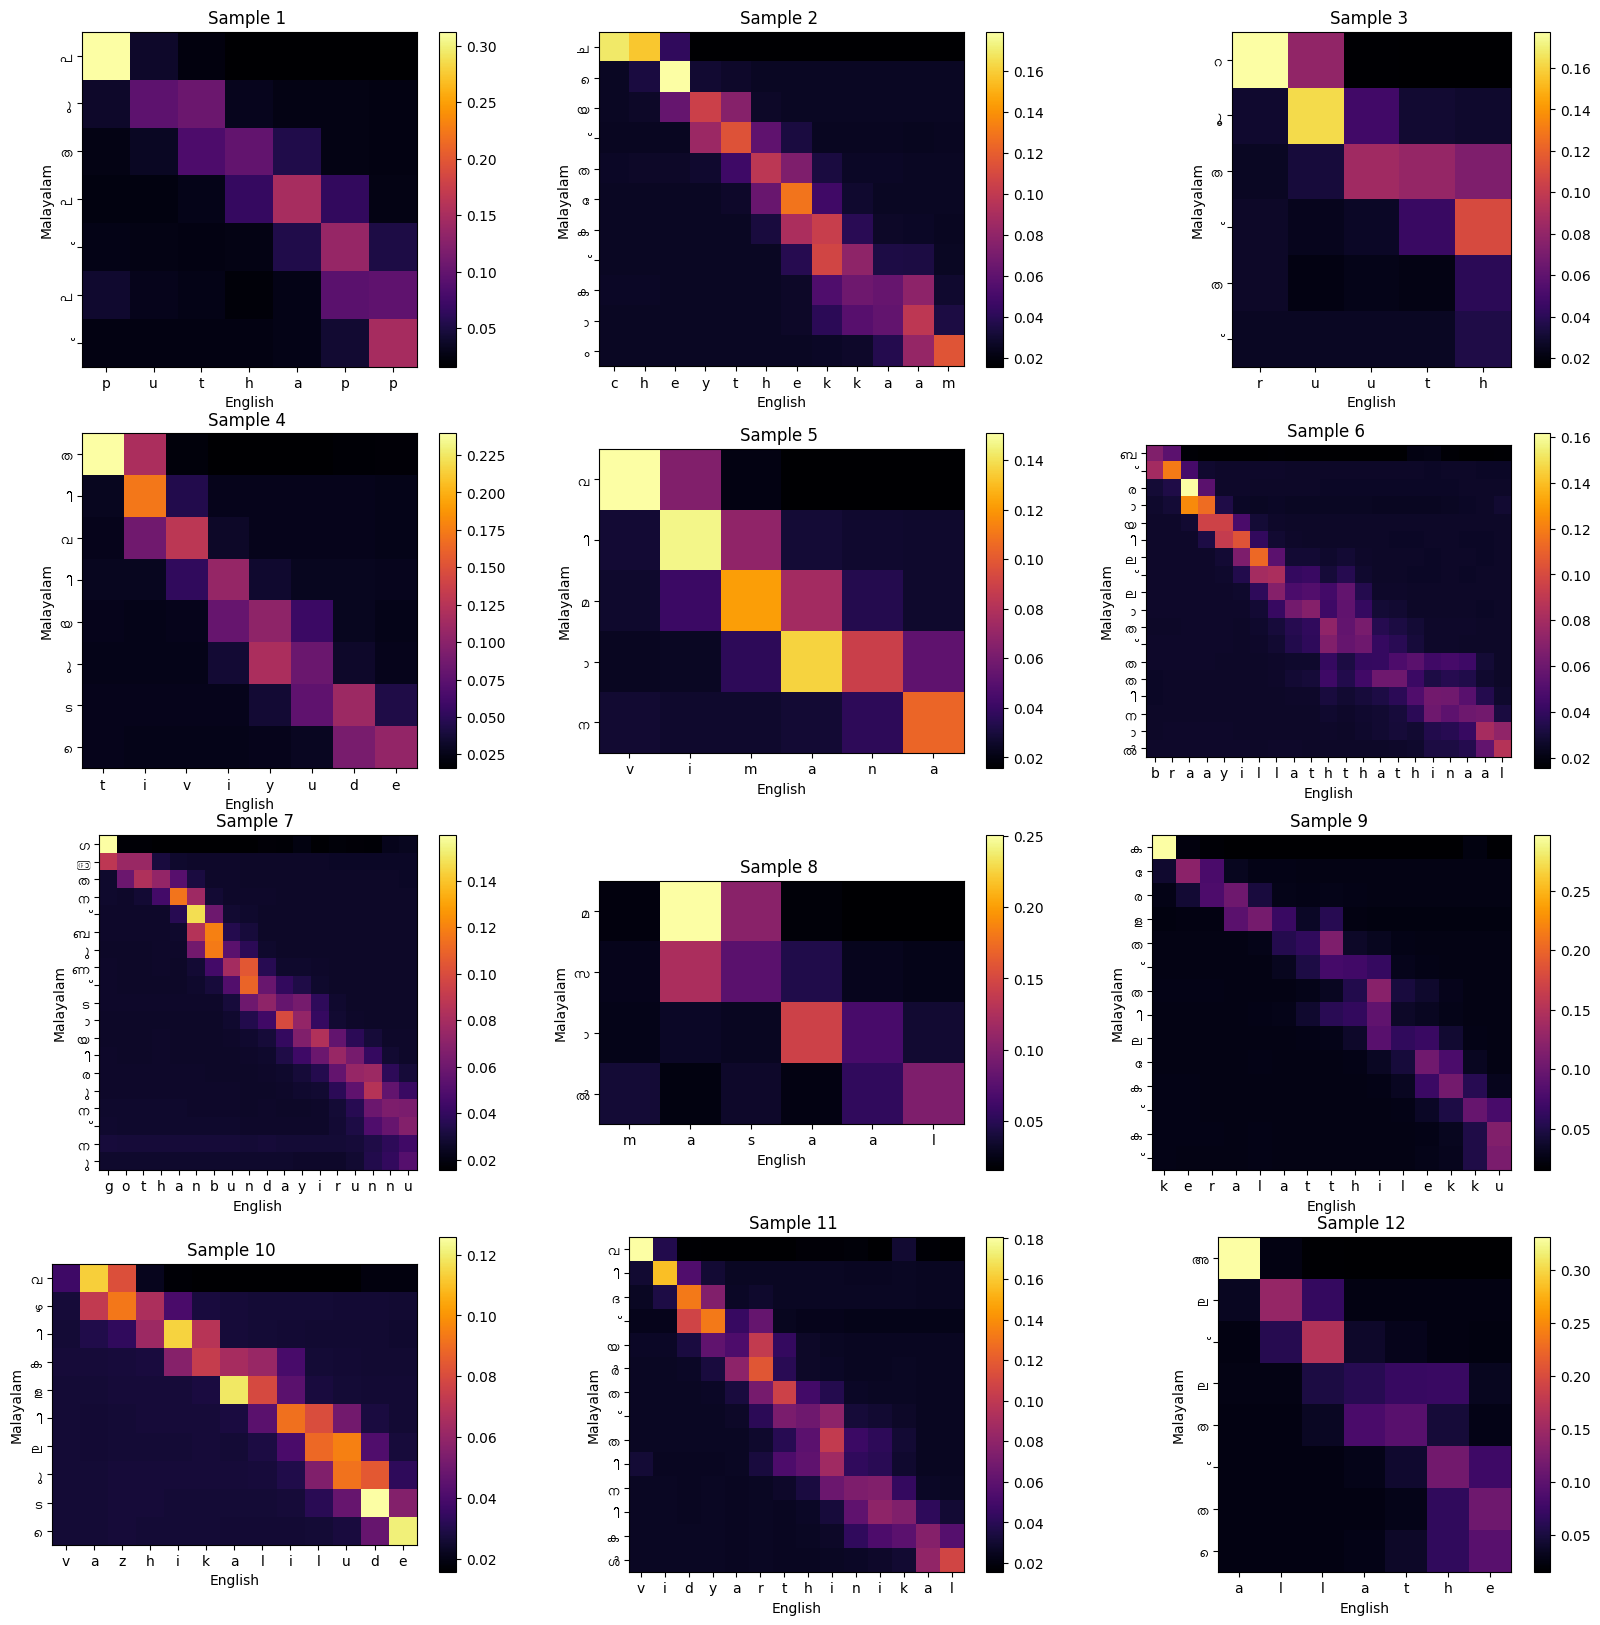

In [44]:
# Plot attention hmap
def prepare_ticks(input_data, output_data, index):
    filter_func = lambda x: x.item() not in [0, 1, 2]
    x_ticks = [english_index_dict[i.item()] for i in input_data[index] if filter_func(i)]
    y_ticks = [malayalam_index_dict[i.item()] for i in output_data[index] if filter_func(i)]
    return x_ticks, y_ticks

def generate_heatmap(input_data, output_data, weights, num_plots=12):
    fig, ax = plt.subplots(4, 3, figsize=(20, 20))
    plt.setp(ax)

    for idx in range(num_plots):
        x_ticks, y_ticks = prepare_ticks(input_data, output_data, idx)
        heatmap_data = weights[:, :, idx].detach().cpu().numpy()
        heatmap_data = heatmap_data[1:len(y_ticks)+1, 2:len(x_ticks)+2]

        plt.sca(ax[idx//3, idx%3])
        plt.imshow(heatmap_data, interpolation='nearest', cmap='inferno')
        plt.colorbar()
        plt.xticks(np.arange(0, len(x_ticks)), x_ticks)

        mal_font = FontProperties(fname='/kaggle/input/attention-heatmap/AnjaliOldLipi-Regular.ttf')
        plt.yticks(np.arange(0, len(y_ticks)), y_ticks, fontproperties=mal_font)

        plt.xlabel('English')
        plt.ylabel('Malayalam')
        plt.title(f'Sample {idx + 1}')

    plt.show()

    canvas = plt.gca().figure.canvas
    canvas.draw()
    image_data = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)
    image = image_data.reshape(canvas.get_width_height()[::-1] + (3,))
    
    return image

output_softmax = F.softmax(test_output, dim=2)
output_argmax = torch.argmax(output_softmax, dim=2).T
mean_weights = torch.mean(_weights, axis=2)
image = generate_heatmap(test_input, output_argmax, mean_weights)

In [48]:
sweep_config = {
    'method': 'grid',
    'name' : 'attention_plot',
    'parameters': {
        'beam_size': {
            'values': [1]
        }
  }
}

sweep_id = wandb.sweep(sweep = sweep_config, entity="abhinavtk", project='MA23M002-A3')

Create sweep with ID: zci4jt5n
Sweep URL: https://wandb.ai/abhinavtk/MA23M002-A3/sweeps/zci4jt5n


In [49]:
def main():
    with wandb.init() as run:
        #run_name = "-f_num_"+str(wandb.config.filters_num)+"-f_num_"+wandb.config.filter_org+"-ac_fn_"+wandb.config.act_fn+\
                    #"-b_norm_"+str(wandb.config.batch_norm) + "-bs_"+str(wandb.config.batch_size) +"-neu_num"+str(wandb.config.num_neurons_dense)

        wandb.run.name = "attention_heatmap"
        #wandb.log({"image_pred": [wandb.Image(image, caption="Test Images and Predictions")]})
        wandb.log({"image_grid": [wandb.Image(image, caption="Attention Heatmap")]})
wandb.agent(sweep_id, function = main, count = 1)
wandb.finish()

wandb: Agent Starting Run: lg3t9yqd with config:
wandb: 	beam_size: 1
